In [1]:
import sys
import os
import numpy as np
from matplotlib import pyplot as plt
sys.path.append(os.path.abspath(".."))  #TODO: MAKE THE SRC PACKAGE WORK
#from src.training.train import train_model, train_cellfate
from src.evaluation.evaluate import Evaluation
from src.training.loss_functions import *

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from keras.layers import Lambda, Input, GaussianNoise,concatenate, Dense, Dropout, Conv2D, Add, UpSampling2D, Dot, Conv2DTranspose, Activation, Reshape, InputSpec, LeakyReLU, Flatten, BatchNormalization, SpectralNormalization, GlobalAveragePooling2D
from keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
import keras.backend as K
from keras import activations, initializers, regularizers, constraints
from tensorflow.python.keras.utils import conv_utils
from keras.layers import Dense, Conv1D, Conv2D, Conv3D, Conv2DTranspose, Embedding
import tensorflow as tf
from keras.models import load_model
from keras.applications import VGG19, VGG16
from keras.activations import swish
from keras.initializers import glorot_uniform, glorot_normal, GlorotUniform
from keras.constraints import max_norm, UnitNorm
from ipywidgets import interact, IntSlider
import tifffile as tiff
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [3]:
# x_train = np.load('../data/stretched_x_train.npy')
# x_test = np.load('../data/stretched_x_test.npy')
# x_train = np.load('../data/centered_x_train.npy')
# y_train = np.load('../data/train_labels.npy')
# x_test = np.load('../data/centered_x_test.npy')
# y_test = np.load('../data/test_labels.npy')

x_train = np.load('../data/images/time_norm_train_images.npy')[:,0,:,:]
y_train = np.load('../data/labels/train_labels_augmented4.npy')
x_test = np.load('../data/images/time_norm_test_images.npy')[:,0,:,:]
y_test = np.load('../data/labels/test_labels.npy')

# x_train = np.load('../data/images/time_norm_smaller_train_images10.npy')[:,0,:,:]
# y_train = np.load('../data/labels/smaller_train_labels_augmented10.npy')
# x_test = np.load('../data/images/stretched_x_test_from_smaller10.npy')[:,0,:,:]

# x_train = np.load('../data/images/train_images_augmented4_stretched.npy')[:,0,:,:]
# y_train = np.load('../data/labels/train_labels_augmented.npy')
# x_test = np.load('../data/images/test_images_augmented4_stretched.npy')[:,0,:,:]
# y_test = np.load('../data/labels/test_labels.npy')


# # after I train again:
# x_train = np.load('/Users/inescunha/Documents/GitHub/CellFate/data/images/stretched_x_train.npy')
# y_train = np.load('/Users/inescunha/Documents/GitHub/CellFate/data/labels/train_labels_augmented.npy')
# x_test = np.load('/Users/inescunha/Documents/GitHub/CellFate/data/images/stretched_x_test.npy')
# y_test = np.load('/Users/inescunha/Documents/GitHub/CellFate/data/labels/test_labels.npy')

# augmented_x_test = np.load('/Users/inescunha/Documents/GitHub/CellFate/data/images/stretched_x_test_augmented.npy')
# augmented_y_test = np.load('/Users/inescunha/Documents/GitHub/CellFate/data/labels/test_labels_augmented.npy')


# With Imagenet

In [ ]:


base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

num_classes = len(np.unique(y_train))
# Build a new model for your task
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pooling to flatten feature maps
x = Dense(512, activation='relu')(x)  
x = Dropout(0.5)(x)
outputs = Dense(num_classes, activation='softmax')(x)
# Final model
clf_model = Model(inputs=base_model.input, outputs=outputs)

# Freeze VGG19 layers for transfer learning
for layer in base_model.layers:
    layer.trainable = False

tf.keras.utils.set_random_seed(42)

clf_model.compile(loss="sparse_categorical_crossentropy", optimizer=Adam(learning_rate=0.0001, clipvalue=0.5), metrics=["accuracy"])

clf_model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 32, 32, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 32, 32, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 16, 16, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 8, 8, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 4, 4, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 2, 2, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │         1,026 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,978,370 (57.14 MB)

 Trainable params: 263,682 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [15]:
def process_for_vgg(image): # the input is (20, 20)
    # Pad to make it the minimum size for VGG (32, 32, 3)
    image = np.expand_dims(image, axis=-1)
    padded_x_train = np.pad(image, ((0, 0), (6, 6), (6, 6), (0, 0)), mode='constant')
    padded_x_train = np.concatenate((padded_x_train, padded_x_train), axis=-1)
    padded_x_train = np.concatenate((padded_x_train, padded_x_train[:,:,:,0:1]), axis=-1)
    return padded_x_train

x_val, x_test_, y_val, y_test_ = train_test_split(x_test, y_test, test_size=0.5, random_state=42)

history = clf_model.fit(process_for_vgg(x_train), y_train, batch_size=32, epochs=100, validation_data=(process_for_vgg(x_val), y_val))

plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

Epoch 1/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 5s 61ms/step - accuracy: 0.5319 - loss: 0.7317 - val_accuracy: 0.6667 - val_loss: 0.6395
Epoch 2/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 59ms/step - accuracy: 0.6153 - loss: 0.6691 - val_accuracy: 0.6522 - val_loss: 0.6478
Epoch 3/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - accuracy: 0.6280 - loss: 0.6673 - val_accuracy: 0.6449 - val_loss: 0.6458
Epoch 4/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6337 - loss: 0.6452 - val_accuracy: 0.6304 - val_loss: 0.6348
Epoch 5/100
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - accuracy: 0.6293 - loss: 0.6435 - val_accuracy: 0.6522 - val_loss: 0.6119
Epoch 6/100
43/69 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.6589 - loss: 0.6299

KeyboardInterrupt: 

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
[[0.62162162 0.37837838]
 [0.32142857 0.67857143]]


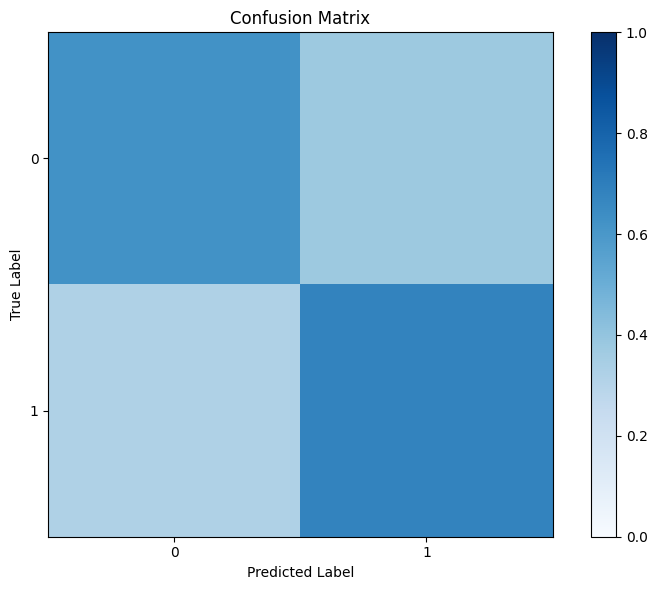

In [6]:
num_classes = len(np.unique(y_train))
y_pred = clf_model.predict(process_for_vgg(x_test_))
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test_, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [ ]:
np.mean(np.diag(conf_matrix_normalized))

# CellFate workflow statistics

In [4]:
from src.models import Encoder, Decoder, Discriminator, mlp_classifier

config = {
    'batch_size': 30,
    'epochs': 50,
    'learning_rate': 0.001,
    'seed': 42,
    'latent_dim': 2,
    'GaussianNoise_std': 0.003,
    'lambda_recon': 5, 
    'lambda_adv': 0.05,
    'lambda_clf': 0.05,
    'lambda_cov': 0.1,
}

img_shape = (x_train.shape[1], x_train.shape[2], 1)
encoder = Encoder(img_shape=img_shape, latent_dim=config['latent_dim'], num_classes=2, gaussian_noise_std=config['GaussianNoise_std']).model
decoder = Decoder(latent_dim=config['latent_dim'], img_shape=img_shape, gaussian_noise_std=config['GaussianNoise_std']).model
discriminator = Discriminator(latent_dim=config['latent_dim']).model

# encoder.load_weights("/Users/inescunha/Downloads/encoder60.weights.h5")
# decoder.load_weights("/Users/inescunha/Downloads/decoder60.weights.h5")

# encoder.load_weights("/Users/inescunha/Downloads/encoder.weights.h5")
# decoder.load_weights("/Users/inescunha/Downloads/decoder.weights.h5")

encoder.load_weights("/Users/inescunha/Documents/GitHub/CellFate/results/models/autoencoder_cov/encoder.weights.h5")
decoder.load_weights("/Users/inescunha/Documents/GitHub/CellFate/results/models/autoencoder_cov/decoder.weights.h5")
# discriminator.load_weights("/Users/inescunha/Documents/GitHub/CellFate/results/models/autoencoder_cov/discriminator.weights.h5")


/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/inescunha/anaconda3/envs/interpret/lib/python3.10/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [5]:
encoder.predict(x_test).shape

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


(277, 2)

In [5]:
tf.keras.utils.set_random_seed(config['seed'])

classifier = mlp_classifier(latent_dim=config['latent_dim']) #[:, [3, 8]] 

# Train the classifier
classifier.compile(loss='sparse_categorical_crossentropy', optimizer= tf.keras.optimizers.Adam(learning_rate=config['learning_rate']), metrics=['accuracy'])
classifier.summary()

x_val, x_test_, y_val, y_test_ = train_test_split(encoder.predict(x_test), y_test, test_size=0.5, random_state=42) # 42 random state

history = classifier.fit(encoder.predict(x_train), y_train, batch_size=config['batch_size'], epochs=config['epochs'], validation_data=(x_val, y_val)) # 

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dropout_5 (Dropout)             │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 2)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6 (24.00 B)

 Trainable params: 6 (24.00 B)

 Non-trainable params: 0 (0.00 B)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6313 - loss: 0.6932 - val_accuracy: 0.4493 - val_loss: 0.8018
Epoch 2/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 508us/step - accuracy: 0.6565 - loss: 0.6527 - val_accuracy: 0.4928 - val_loss: 0.7505
Epoch 3/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 444us/step - accuracy: 0.6697 - loss: 0.6269 - val_accuracy: 0.5145 - val_loss: 0.7113
Epoch 4/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 455us/step - accuracy: 0.6913 - loss: 0.6024 - val_accuracy: 0.5580 - val_loss: 0.6818
Epoch 5/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step - accuracy: 0.6909 - loss: 0.5925 - val_accuracy: 0.5942 - val_loss: 0.6628
Epoch 6/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 412us/step - accuracy: 0.7064 - loss: 0.5846 - val_accuracy: 0.6159 - val_loss: 0.6452
Epoch 7/50
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 406us/step - accuracy: 0.6865 - loss: 0.5959 - val_accuracy: 0.6232 - val_loss: 0.6339
Epoch 8/50
73/73 ━━━━━━━━━━━━

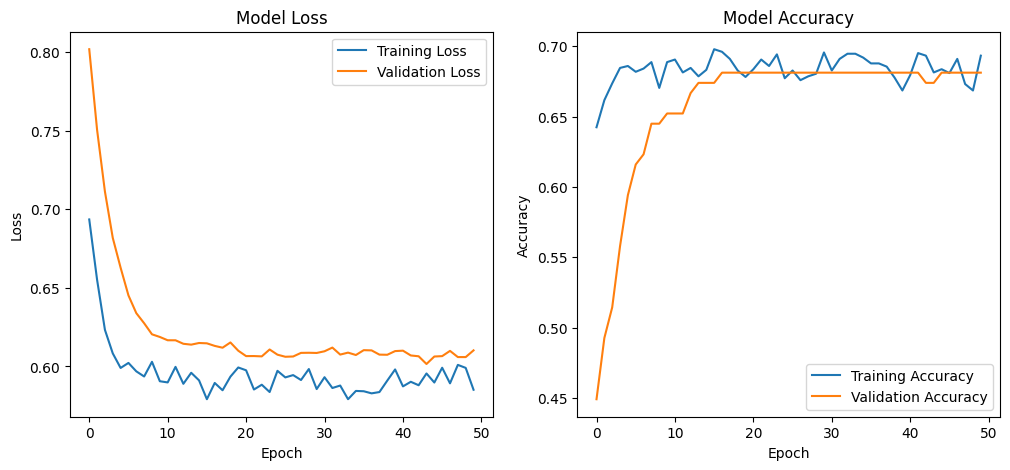

In [6]:
plt.figure(figsize=(12, 5))

# Plot training & validation loss values
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
[[0.65765766 0.34234234]
 [0.21428571 0.78571429]]


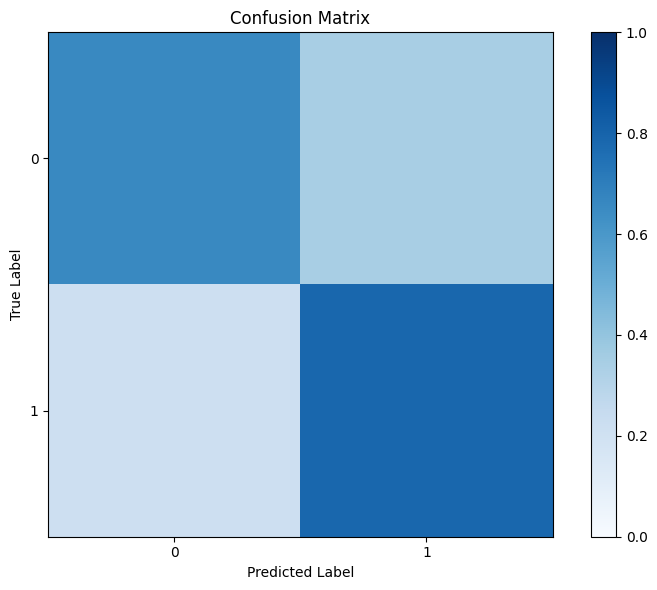

In [7]:
#### LAMBDA CONTRASTIVE LOSS = 4

num_classes = len(np.unique(y_train))
y_pred = classifier.predict(x_test_)
y_pred_classes = np.argmax(y_pred, axis=1)

# Calculate confusion matrix
cm = confusion_matrix(y_test_, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, range(num_classes))
plt.yticks(tick_marks, range(num_classes))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [13]:
precison = conf_matrix_normalized[0,0] / (conf_matrix_normalized[0,0] + conf_matrix_normalized[1,0])

In [14]:
precison

0.6191383911551659

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 561us/step
[[0.58558559 0.41441441]
 [0.46428571 0.53571429]]


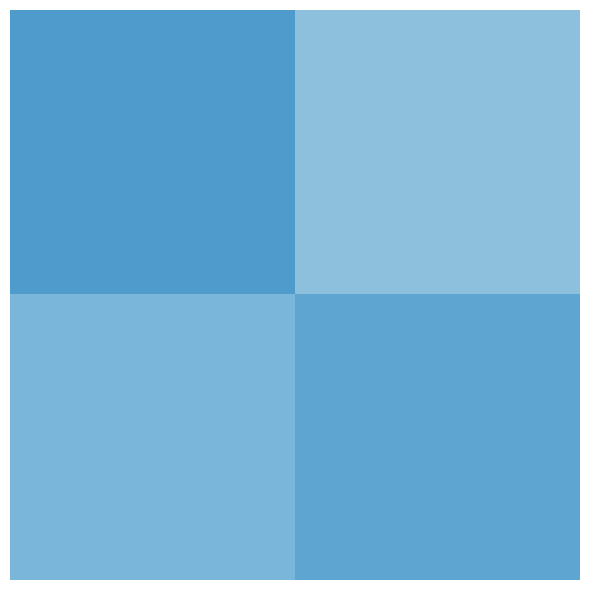

In [ ]:
#### LAMBDA CONTRASTIVE LOSS = 4

num_classes = len(np.unique(y_train))
y_pred = classifier.predict(x_test_)
# y_pred_classes = np.argmax(y_pred, axis=1)

threshold = 0.5
y_pred_classes = np.zeros_like(y_pred[:, 1])  # Initialize as class 0
y_pred_classes[y_pred[:, 1] > threshold] = 1  

# Calculate confusion matrix
cm = confusion_matrix(y_test_, y_pred_classes)

class_sums = cm.sum(axis=1, keepdims=True)
conf_matrix_normalized = cm / class_sums

print(conf_matrix_normalized)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(conf_matrix_normalized, interpolation='nearest', cmap=plt.cm.Blues, vmin=0, vmax=1)
plt.axis('off')
plt.tight_layout()
#plt.savefig("confusion_matrix_aeonly_naked.pdf", format="pdf", dpi=300, pad_inches=0)
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 583us/step


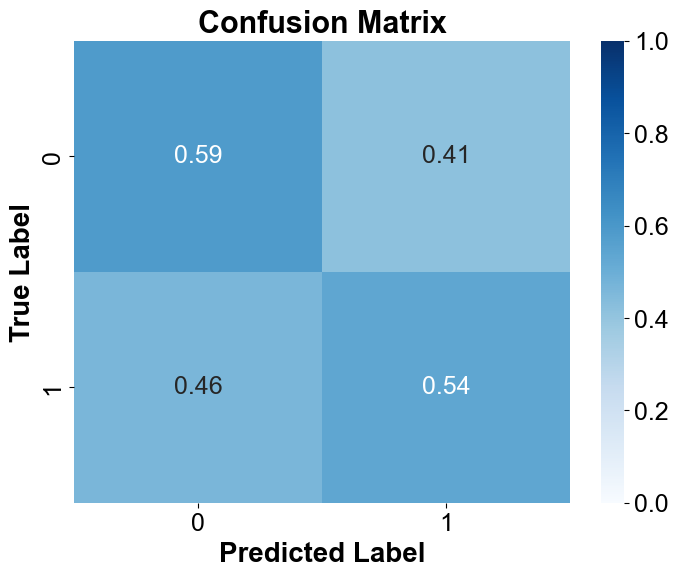

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Define Arial font settings
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 18  # Make text larger

# Compute confusion matrix
num_classes = len(np.unique(y_train))
y_pred = classifier.predict(x_test_)

# Use thresholding for binary classification or softmax for multi-class
threshold = 0.5
y_pred_classes = np.zeros_like(y_pred[:, 1])  # Initialize as class 0
y_pred_classes[y_pred[:, 1] > threshold] = 1  

# Calculate confusion matrix
cm = confusion_matrix(y_test_, y_pred_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)

# Plot confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", vmin=0, vmax=1, 
            xticklabels=range(num_classes), yticklabels=range(num_classes), ax=ax)

# Labels and title
ax.set_xlabel("Predicted Label", fontsize=20, fontweight="bold")
ax.set_ylabel("True Label", fontsize=20, fontweight="bold")
ax.set_title("Confusion Matrix", fontsize=22, fontweight="bold")

# Save as SVG for high-quality output
plt.savefig("confusion_matrix_aeonly.pdf", format="pdf", dpi=300)
plt.show()

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


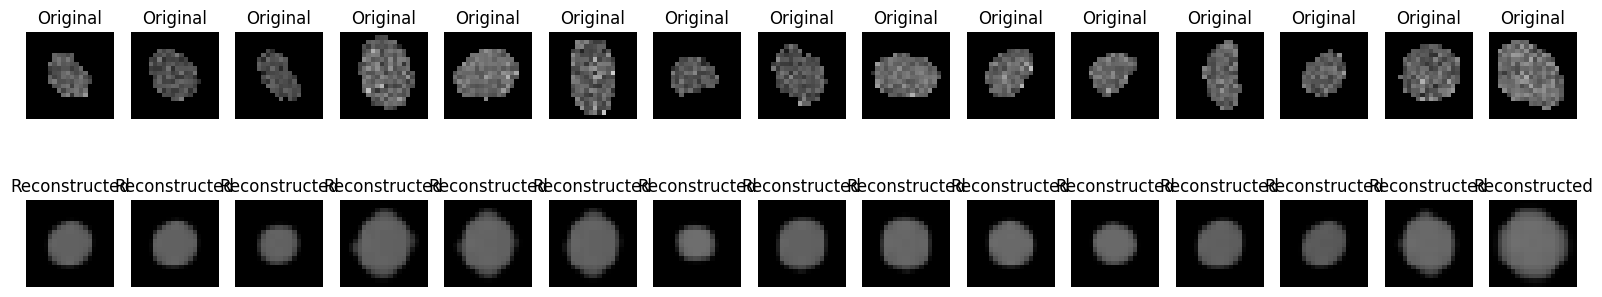

In [9]:
image_batch = x_train
recon_imgs = decoder.predict(encoder.predict(image_batch))
n = 15
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(image_batch[i][:, :], cmap="gray", vmin=0.0, vmax=image_batch.max())
    plt.title("Original")
    plt.axis("off")
   # plt.colorbar()

    # Display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(recon_imgs[i][:, :], cmap="gray", vmin=0.0, vmax=image_batch.max())
    plt.title("Reconstructed")
    plt.axis("off")
  #  plt.colorbar()
#plt.tight_layout()

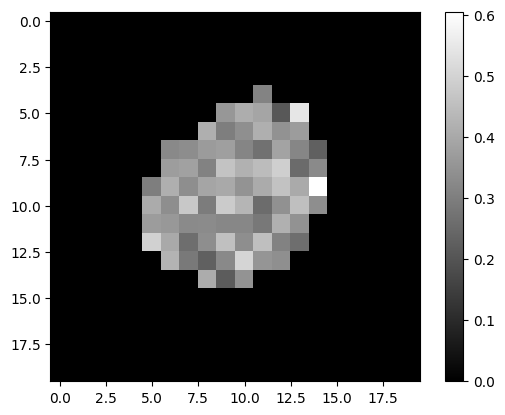

In [10]:
plt.imshow(image_batch[12][:, :], cmap="gray")
plt.colorbar()

In [66]:
x_train_full = np.load('../data/images/time_norm_train_images.npy')

In [68]:
x_train_full.shape

(2184, 11, 20, 20)

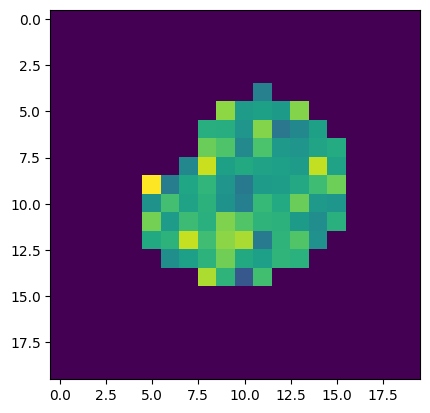

In [73]:
plt.imshow(x_train_full[12,1,:,:])

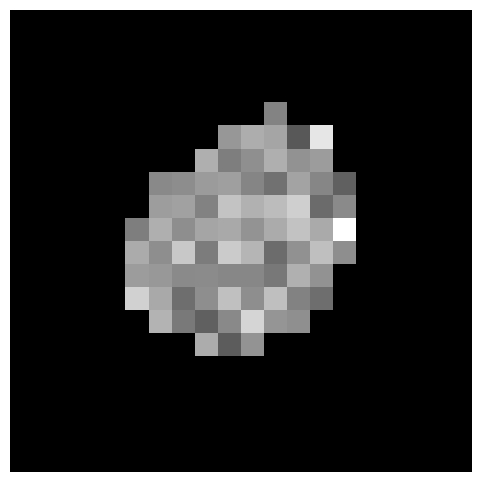

In [65]:
plt.figure(figsize=(6, 6))  # Adjust size as needed
plt.imshow(image_batch[12][:, :], cmap="gray", vmin=0, vmax=image_batch[12][:, :].max())

# Remove axes for a clean figure
plt.axis("off")

# Save as a high-quality PDF
plt.savefig("x_train_12.pdf", format="pdf", dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()

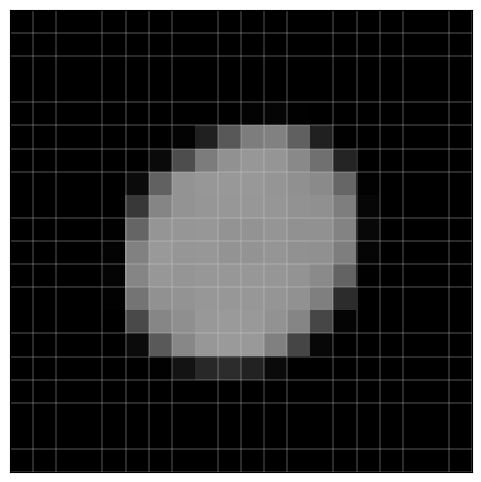

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Load your image
image = recon_imgs[12][:, :]  # Assuming this is your grayscale image

# Define figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Show the image
ax.imshow(image, cmap="gray", vmin=0, vmax=image_batch[12][:, :].max())

# Add a pixel grid
ax.set_xticks(np.arange(image.shape[1] + 1) - 0.5, minor=True)  # Vertical grid lines
ax.set_yticks(np.arange(image.shape[0] + 1) - 0.5, minor=True)  # Horizontal grid lines
ax.grid(which="minor", color="lightgray", linestyle="-", linewidth=0.3)  # Thin, light gray grid

# Remove major ticks
ax.tick_params(which="both", bottom=False, left=False, labelbottom=False, labelleft=False)

# Save with grid
plt.savefig("reconstructed_image_with_grid.pdf", format="pdf", dpi=300, bbox_inches="tight", pad_inches=0)

plt.show()


In [24]:
image.shape

(20, 20, 1)

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
       11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5])

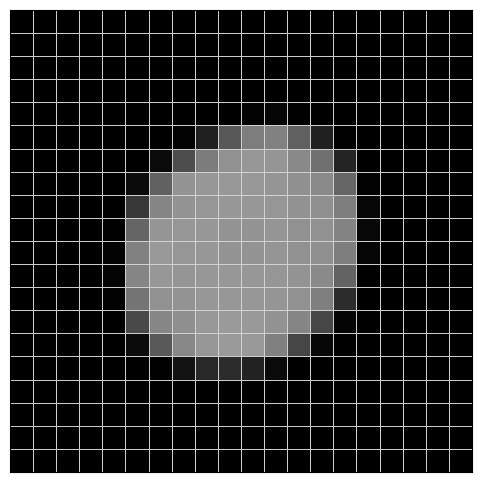

In [64]:
import matplotlib.pyplot as plt
import numpy as np

# Load your image
image = recon_imgs[12][:, :,0]  # Assuming this is your grayscale image
h, w = image.shape  # Get image dimensions

x_limits = [ 0.5,  1.5, 2.5003, 2.5,  3.5,  4.4997,  5.5,  6.5,  7.5, 7.5003 ,8.5,  9.4997, 10.5,
       11.5, 12.5,12.5003 , 13.5, 14.4997, 15.5, 16.5, 17.5, 17.5003, 18.5, 19.5] #np.arange(0.5, w, 1)
y_limits = [ 0.5,  1.5, 2.5003, 2.5,  3.5,  4.4997,  5.5,  6.5,  7.5, 7.5003 ,8.5,  9.4997, 10.5,
       11.5, 12.5,12.5003 , 13.5, 14.4997, 15.5, 16.5, 17.5, 17.5003, 18.5, 19.5]#np.arange(0.5, h, 1)
# Define figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Show the image
ax.imshow(image, cmap="gray", vmin=0, vmax=image_batch[12][:, :].max())

# Add a pixel grid (ensuring no missing lines)
ax.set_xticks(x_limits, minor=True)  # Vertical grid lines
ax.set_yticks(y_limits, minor=True)  # Horizontal grid lines
ax.grid(which="minor", color="lightgray", linestyle="-", linewidth=0.7)  # Thin, light gray grid

# Remove major ticks
ax.tick_params(which="both", bottom=False, left=False, labelbottom=False, labelleft=False)

# Save with grid
plt.savefig("reconstructed_image_with_grid_fixed.pdf", format="pdf", dpi=300, bbox_inches="tight", pad_inches=0)

plt.show()


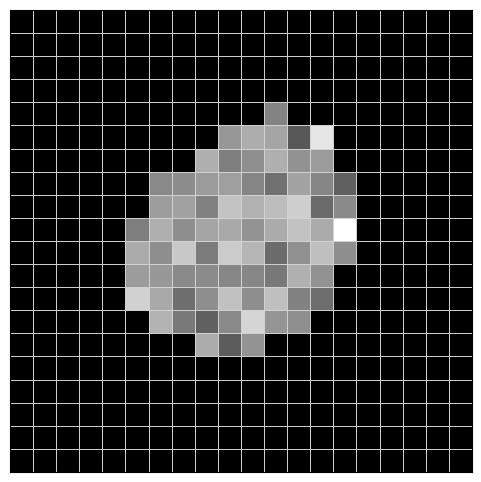

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Load your image
image = image_batch[12][:, :]  # Assuming this is your grayscale image
h, w = image.shape  # Get image dimensions

x_limits = [ 0.5,  1.5, 2.5003, 2.5,  3.5,  4.4997,  5.5,  6.5,  7.5, 7.5003 ,8.5,  9.4997, 10.5,
       11.5, 12.5,12.5003 , 13.5, 14.4997, 15.5, 16.5, 17.5, 17.5003, 18.5, 19.5] #np.arange(0.5, w, 1)
y_limits = [ 0.5,  1.5, 2.5003, 2.5,  3.5,  4.4997,  5.5,  6.5,  7.5, 7.5003 ,8.5,  9.4997, 10.5,
       11.5, 12.5,12.5003 , 13.5, 14.4997, 15.5, 16.5, 17.5, 17.5003, 18.5, 19.5]#np.arange(0.5, h, 1)
# Define figure and axis
fig, ax = plt.subplots(figsize=(6, 6))

# Show the image
ax.imshow(image, cmap="gray", vmin=0, vmax=image_batch[12][:, :].max())

# Add a pixel grid (ensuring no missing lines)
ax.set_xticks(x_limits, minor=True)  # Vertical grid lines
ax.set_yticks(y_limits, minor=True)  # Horizontal grid lines
ax.grid(which="minor", color="lightgray", linestyle="-", linewidth=0.7)  # Thin, light gray grid

# Remove major ticks
ax.tick_params(which="both", bottom=False, left=False, labelbottom=False, labelleft=False)

# Save with grid
plt.savefig("image_with_grid_fixed.pdf", format="pdf", dpi=300, bbox_inches="tight", pad_inches=0)

plt.show()


In [24]:
np.arange(0.5, w, 1)

array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
       11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5, 18.5, 19.5])

In [13]:
conf_matrix_normalized

array([[0.65765766, 0.34234234],
       [0.21428571, 0.78571429]])

In [10]:
# calculate precision and recall
precision = conf_matrix_normalized[0,0] / (conf_matrix_normalized[0,0] + conf_matrix_normalized[1,0])

In [11]:
precision

0.7082785808147175

In [12]:
np.mean(np.diag(conf_matrix_normalized))

0.7039897039897041

In [6]:
def visualize_latent_space(latent_space, y_train):
    """Visualize latent space features and their correlation with labels."""
    cor_vals = [np.corrcoef(np.eye(2)[y_train][:, 0], latent_space[:, i])[0, 1] for i in range(latent_space.shape[1])]
    cor_vals = np.array(cor_vals)
    feat_0, feat_1 = np.argsort(np.abs(cor_vals))[-2:]  # Find top 2 correlated features

    print(f"Top correlated features: {feat_0}, {feat_1}")

    # Scatter plot
    scatter = plt.scatter(latent_space[:, feat_0], latent_space[:, feat_1], c=y_train, cmap='viridis', alpha=0.7)
    plt.xlabel(f"Latent Variable {feat_0}")
    plt.ylabel(f"Latent Variable {feat_1}")
    plt.title("Latent Space")
    plt.grid(True)

    # Add legend
    handles, _ = scatter.legend_elements()
    plt.legend(handles, ['Fate 0', 'Fate 1'], title="Classes", loc="lower right")

In [9]:
import numpy as np

# Get latent space representation
latent_x_test = encoder.predict(x_test)  # Shape: (num_samples, latent_dim)

# Select the two latent features to check (e.g., feature 0 and feature 1)
feature_0 = latent_x_test[:, 0]
feature_1 = latent_x_test[:, 1]

# Stack features into a matrix (2 rows, num_samples columns)
feature_matrix = np.vstack([feature_0, feature_1])

# Compute covariance matrix
cov_matrix = np.cov(feature_matrix)

print("Covariance matrix:")
print(cov_matrix)


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
Covariance matrix:
[[0.59690357 0.01172189]
 [0.01172189 1.15160359]]


In [10]:
corr_matrix = np.corrcoef(feature_0, feature_1)
print("Correlation matrix:")
print(corr_matrix)


Correlation matrix:
[[1.        0.0141382]
 [0.0141382 1.       ]]


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Top correlated features: 0, 1


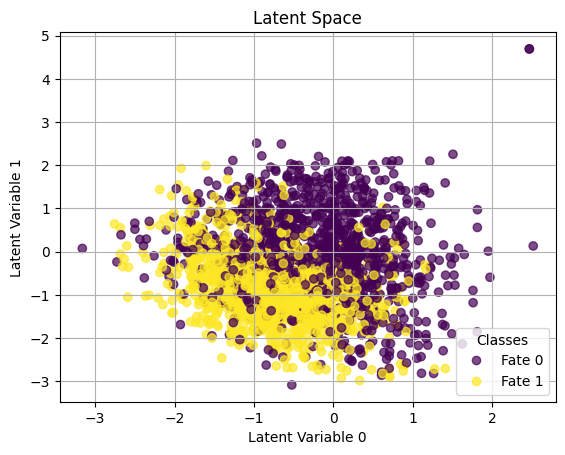

In [11]:
visualize_latent_space(encoder.predict(x_train), y_train)

In [13]:
from scipy.spatial.distance import euclidean

# Compute centroids
centroid_class_0 = np.mean(encoder.predict(x_train)[y_train == 0], axis=0)
centroid_class_1 = np.mean(encoder.predict(x_train)[y_train == 1], axis=0)

# Compute Euclidean distance between centroids
distance = euclidean(centroid_class_0, centroid_class_1)
print(f"Distance between class centroids: {distance:.4f}")


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Distance between class centroids: 0.9862


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


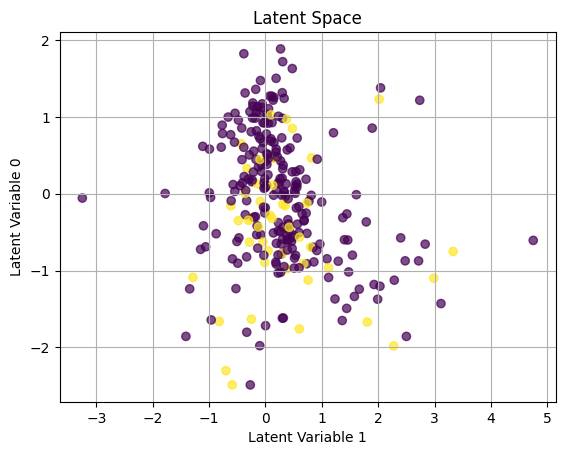

In [10]:
feat_0 = 1
feat_1 = 0
scatter = plt.scatter(encoder.predict(x_test[:,:,:])[:, feat_0], encoder.predict(x_test[:,:,:])[:, feat_1], c=y_test, cmap='viridis', alpha=0.7)
plt.xlabel(f"Latent Variable {feat_0}")
plt.ylabel(f"Latent Variable {feat_1}")
plt.title("Latent Space")
plt.grid(True)

In [11]:
def augment_dataset(cell_images, labels, augmentations, fate_0_label=0, fate_1_label=1):
    
    # Separate fate 0 and fate 1 in the training set
    fate_0_images = cell_images[labels == fate_0_label]
    fate_1_images = cell_images[labels == fate_1_label]
    
    # Augment both classes
    augmented_fate_0 = [augmentations(image) for image in fate_0_images]
    augmented_fate_0 = np.concatenate(augmented_fate_0, axis=0)
    
    augmented_fate_1 = [augmentations(image) for image in fate_1_images]
    augmented_fate_1 = np.concatenate(augmented_fate_1, axis=0)
    
    # Combine augmented data with originals
    fate_0_combined = np.concatenate([fate_0_images, augmented_fate_0], axis=0)
    fate_1_combined = np.concatenate([fate_1_images, augmented_fate_1], axis=0)
    
    # Balance fate 0 by random sampling
    target_count = len(fate_1_combined)
    if len(fate_0_combined) >= target_count:
        # Randomly sample without replacement if enough samples
        balanced_fate_0 = fate_0_combined[np.random.choice(
            len(fate_0_combined), size=target_count, replace=False
        )]
    else:
        # Randomly sample with replacement if not enough samples
        balanced_fate_0 = fate_0_combined[np.random.choice(
            len(fate_0_combined), size=target_count, replace=True
        )]
    
    # Combine balanced datasets
    final_images = np.concatenate([balanced_fate_0, fate_1_combined], axis=0)
    final_labels = np.array([fate_0_label] * len(balanced_fate_0) +
                                   [fate_1_label] * len(fate_1_combined))
    
    # Shuffle the training data
    shuffle_indexes = np.random.permutation(len(final_labels))
    final_images = final_images[shuffle_indexes]
    final_labels = final_labels[shuffle_indexes]
    
    return final_images, final_labels

# Example augmentation function
def augmentations(image):
    augmented = [
        np.flip(image, axis=-1),  # Flip horizontally
        np.flip(image, axis=-2),  # Flip vertically
        np.rot90(image, k=1, axes=(-2, -1)),  # Rotate 90 degrees
        np.rot90(image, k=2, axes=(-2, -1)),  # Rotate 180 degrees
        np.rot90(image, k=3, axes=(-2, -1))  # Rotate 270 degrees
    ]
    return np.array(augmented)

In [12]:
augmented_x_test_for_visuals, augmented_y_test_for_visuals = augment_dataset(x_test, y_test, augmentations)

 1/18 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


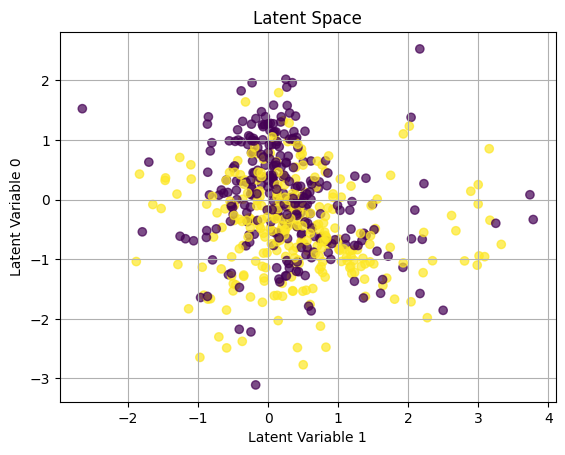

In [13]:
feat_0 = 1
feat_1 = 0
scatter = plt.scatter(encoder.predict(augmented_x_test_for_visuals[:,:,:])[:, feat_0], encoder.predict(augmented_x_test_for_visuals[:,:,:])[:, feat_1], c=augmented_y_test_for_visuals, cmap='viridis', alpha=0.7)
plt.xlabel(f"Latent Variable {feat_0}")
plt.ylabel(f"Latent Variable {feat_1}")
plt.title("Latent Space")
plt.grid(True)

In [14]:
from scipy.spatial.distance import euclidean

# Compute centroids
centroid_class_0 = np.mean(encoder.predict(augmented_x_test_for_visuals)[augmented_y_test_for_visuals == 0], axis=0)
centroid_class_1 = np.mean(encoder.predict(augmented_x_test_for_visuals)[augmented_y_test_for_visuals == 1], axis=0)

# Compute Euclidean distance between centroids
distance = euclidean(centroid_class_0, centroid_class_1)
print(f"Distance between class centroids: {distance:.4f}")


18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Distance between class centroids: 0.5854


In [15]:
from scipy.spatial.distance import euclidean

# Compute centroids
centroid_class_0 = np.mean(encoder.predict(x_test)[y_test == 0], axis=0)
centroid_class_1 = np.mean(encoder.predict(x_test)[y_test == 1], axis=0)

# Compute Euclidean distance between centroids
distance = euclidean(centroid_class_0, centroid_class_1)
print(f"Distance between class centroids: {distance:.4f}")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Distance between class centroids: 0.4691


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


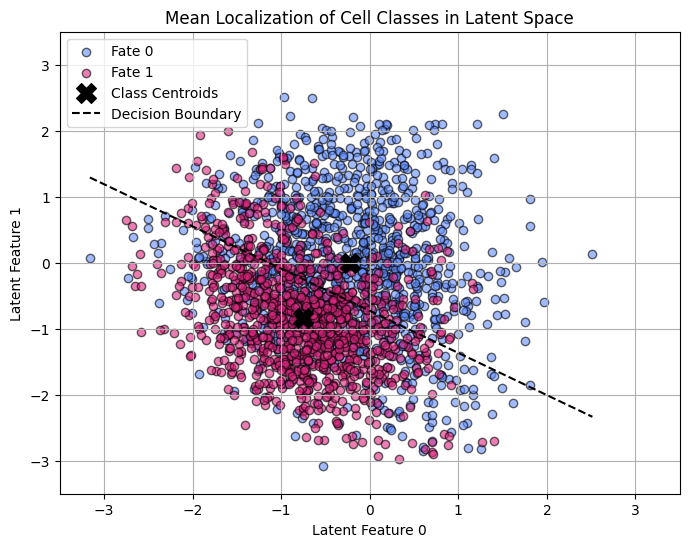

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Predict the latent representations
latent_2d = encoder.predict(x_train)  # Shape (1380, 2)

# Compute mean localization (centroids) for each class
centroid_0 = latent_2d[y_train == 0].mean(axis=0)  # Mean of class 0
centroid_1 = latent_2d[y_train == 1].mean(axis=0)  # Mean of class 1
centroids = np.array([centroid_0, centroid_1])

# Create the plot
plt.figure(figsize=(8, 6))

# Scatter plot for each class separately
plt.scatter(latent_2d[y_train == 0][:, 0], latent_2d[y_train == 0][:, 1], 
            color='#648fff', label="Fate 0", alpha=0.6, edgecolors='k')
plt.scatter(latent_2d[y_train == 1][:, 0], latent_2d[y_train == 1][:, 1], 
            color='#dc267f', label="Fate 1", alpha=0.6, edgecolors='k')

# Plot centroids as black crosses
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=200, label="Class Centroids")

# Decision boundary: Find midpoint of centroids and plot the separating line
x_vals = np.linspace(latent_2d[:, 0].min(), latent_2d[:, 0].max(), 100)
slope = -(centroid_1[0] - centroid_0[0]) / (centroid_1[1] - centroid_0[1])
intercept = (centroid_0[1] + centroid_1[1]) / 2 - slope * (centroid_0[0] + centroid_1[0]) / 2
plt.plot(x_vals, slope * x_vals + intercept, 'k--', label="Decision Boundary")

# Set axis limits
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

plt.xlabel("Latent Feature 0")
plt.ylabel("Latent Feature 1")
plt.title("Mean Localization of Cell Classes in Latent Space")
plt.legend()
plt.grid(True)
plt.show()


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


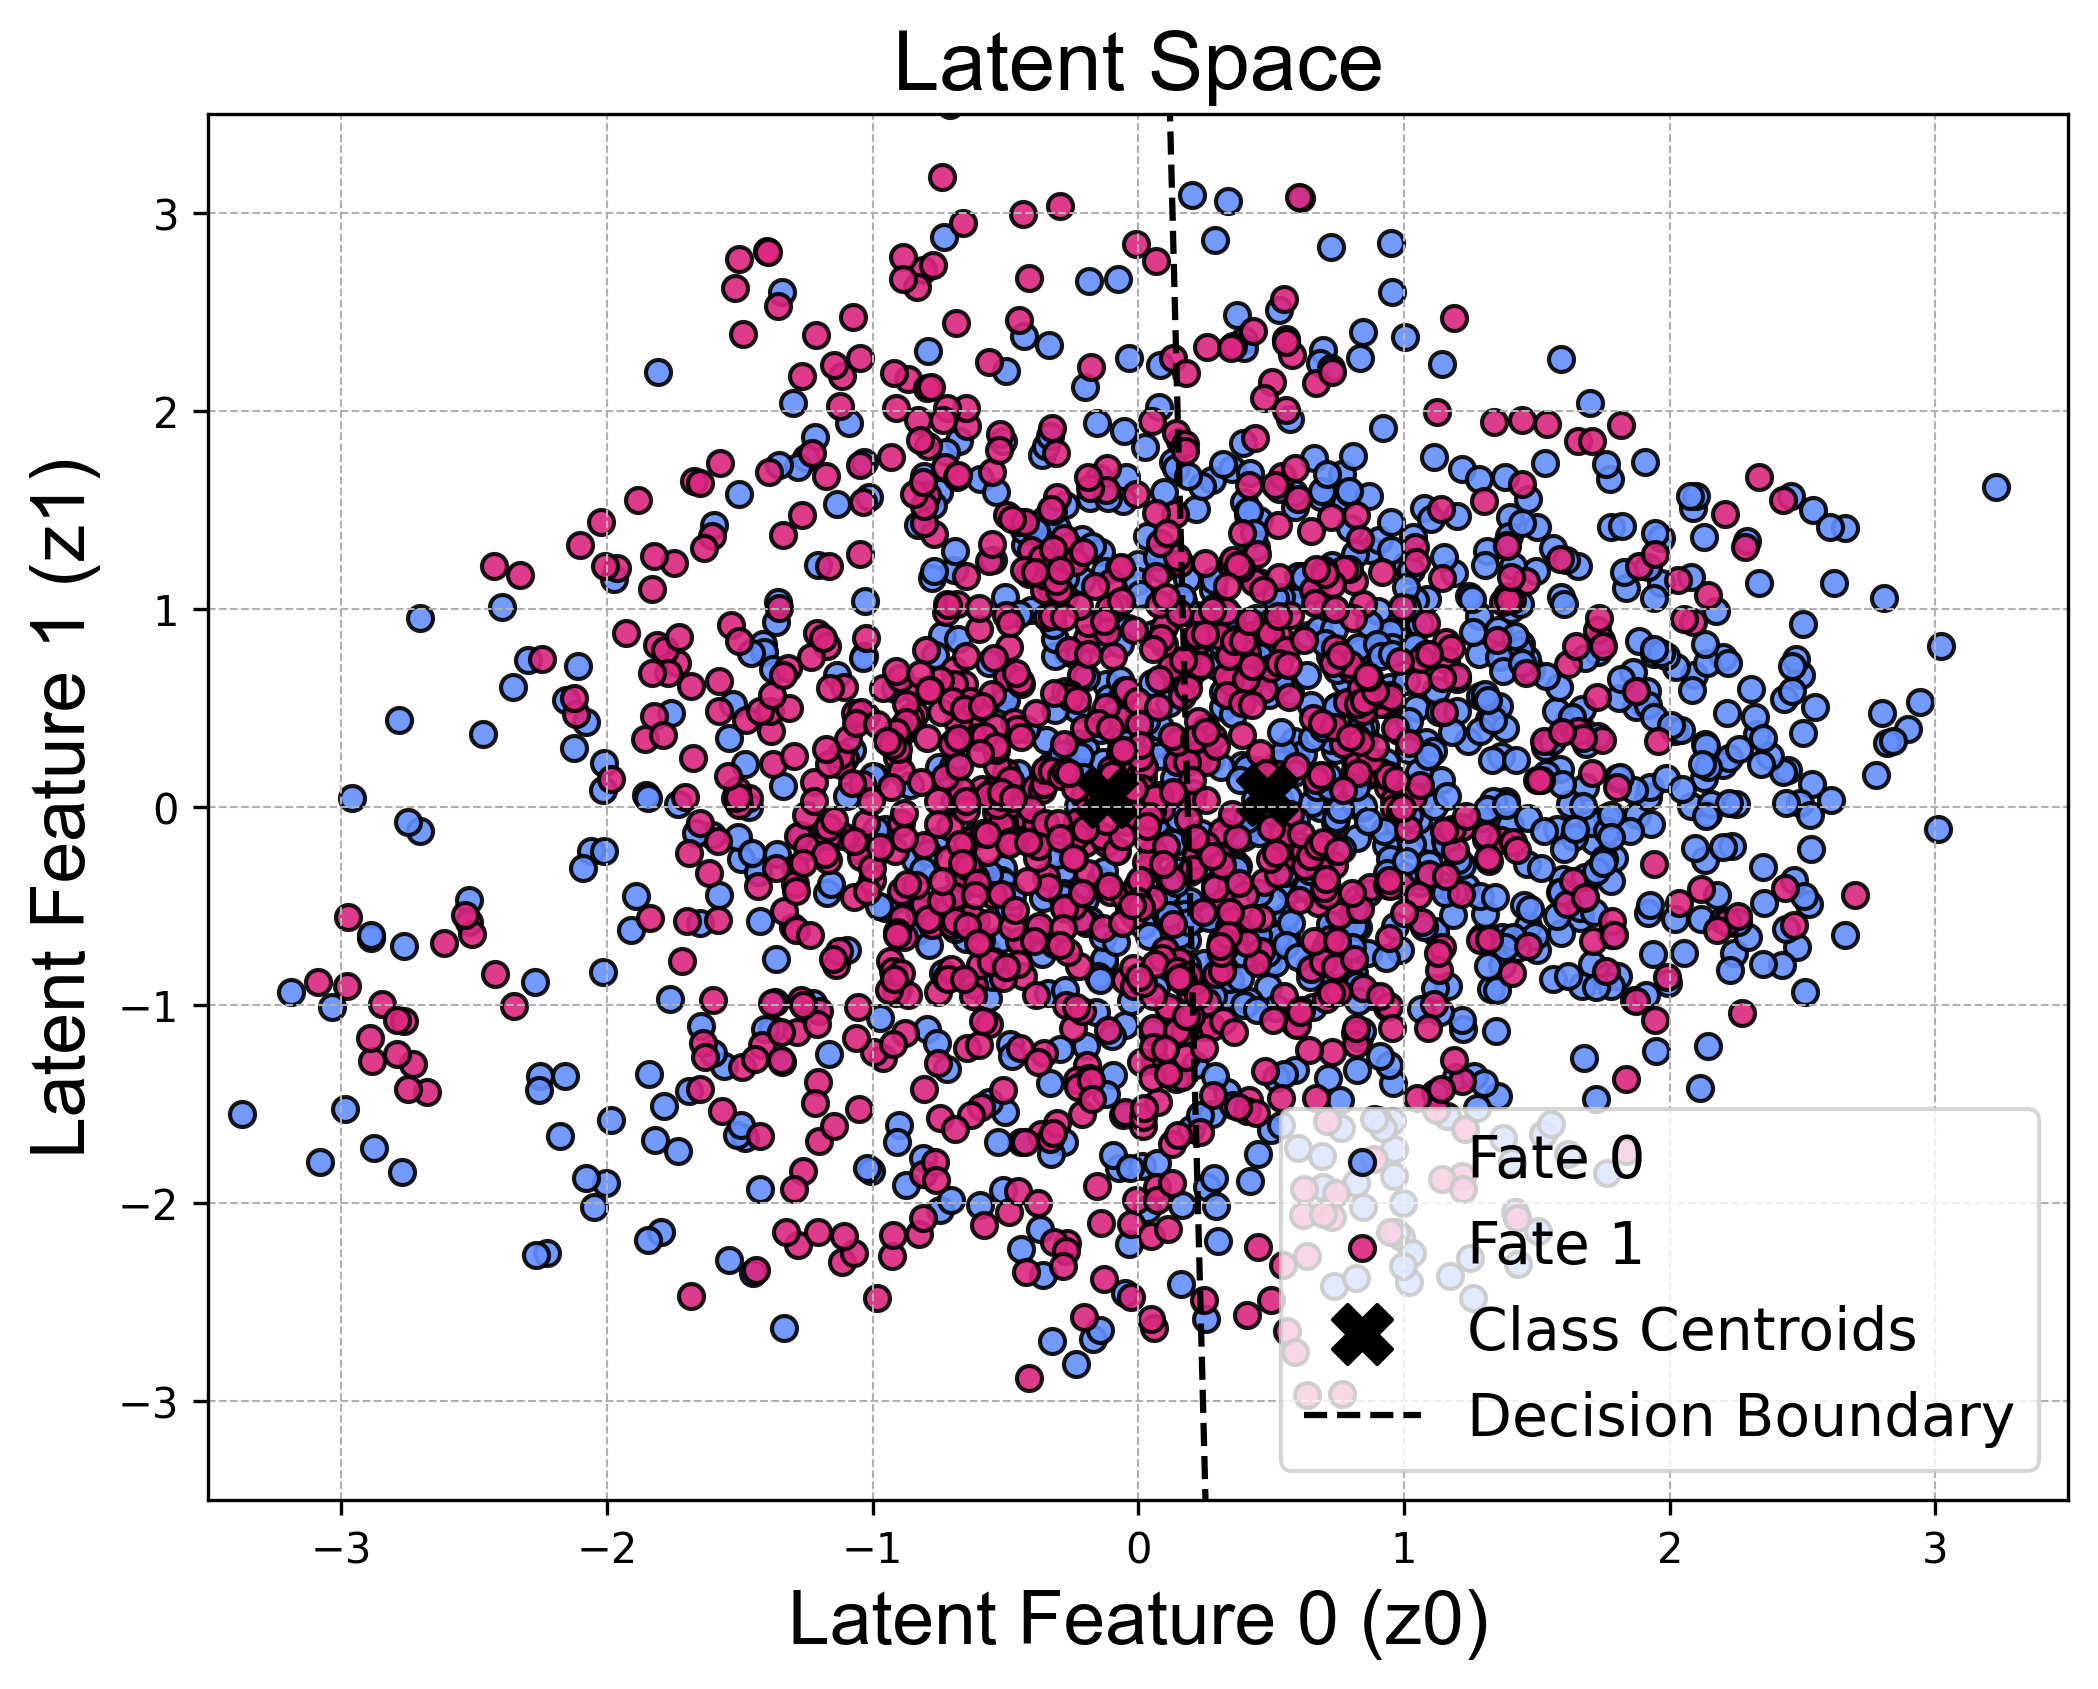

In [7]:
# Predict the latent representations
latent_2d = encoder.predict(x_train)  # Shape (1380, 2)

# Compute mean localization (centroids) for each class
centroid_0 = latent_2d[y_train == 0].mean(axis=0)  # Mean of class 0
centroid_1 = latent_2d[y_train == 1].mean(axis=0)  # Mean of class 1
centroids = np.array([centroid_0, centroid_1])

# Find extreme points for axis limits
x_min, x_max = latent_2d[:, 0].min() - 0.5, latent_2d[:, 0].max() + 0.5
y_min, y_max = latent_2d[:, 1].min() - 0.5, latent_2d[:, 1].max() + 0.5

# Create the plot
plt.figure(figsize=(8, 6), dpi=300)

# Scatter plot for each class separately
plt.scatter(latent_2d[y_train == 0][:, 0], latent_2d[y_train == 0][:, 1], 
            color='#648fff', label="Fate 0", alpha=0.9, edgecolors='k') #
plt.scatter(latent_2d[y_train == 1][:, 0], latent_2d[y_train == 1][:, 1], 
            color='#dc267f', label="Fate 1", alpha=0.9, edgecolors='k') 

# Plot centroids as black crosses
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=200, label="Class Centroids")

# Decision boundary: Find midpoint of centroids and plot the separating line
x_vals = np.linspace(x_min, x_max, 100)
slope = -(centroid_1[0] - centroid_0[0]) / (centroid_1[1] - centroid_0[1])
intercept = (centroid_0[1] + centroid_1[1]) / 2 - slope * (centroid_0[0] + centroid_1[0]) / 2
plt.plot(x_vals, slope * x_vals + intercept, 'k--', label="Decision Boundary")

# Set dynamic axis limits
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)

plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

# Increase font size and set Arial font
plt.xlabel("Latent Feature 0 (z0)", fontsize=18, fontname="Arial")
plt.ylabel("Latent Feature 1 (z1)", fontsize=18, fontname="Arial")
plt.title("Latent Space", fontsize=20, fontname="Arial")
plt.legend(fontsize=14)
plt.grid(True, linestyle="--", linewidth=0.5)

# Save as high-quality SVG and PDF
#plt.savefig("latent_space_cellfate.svg", format="svg", bbox_inches="tight")
plt.savefig("latent_space_aeonly.pdf", format="pdf", bbox_inches="tight")

plt.show()

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


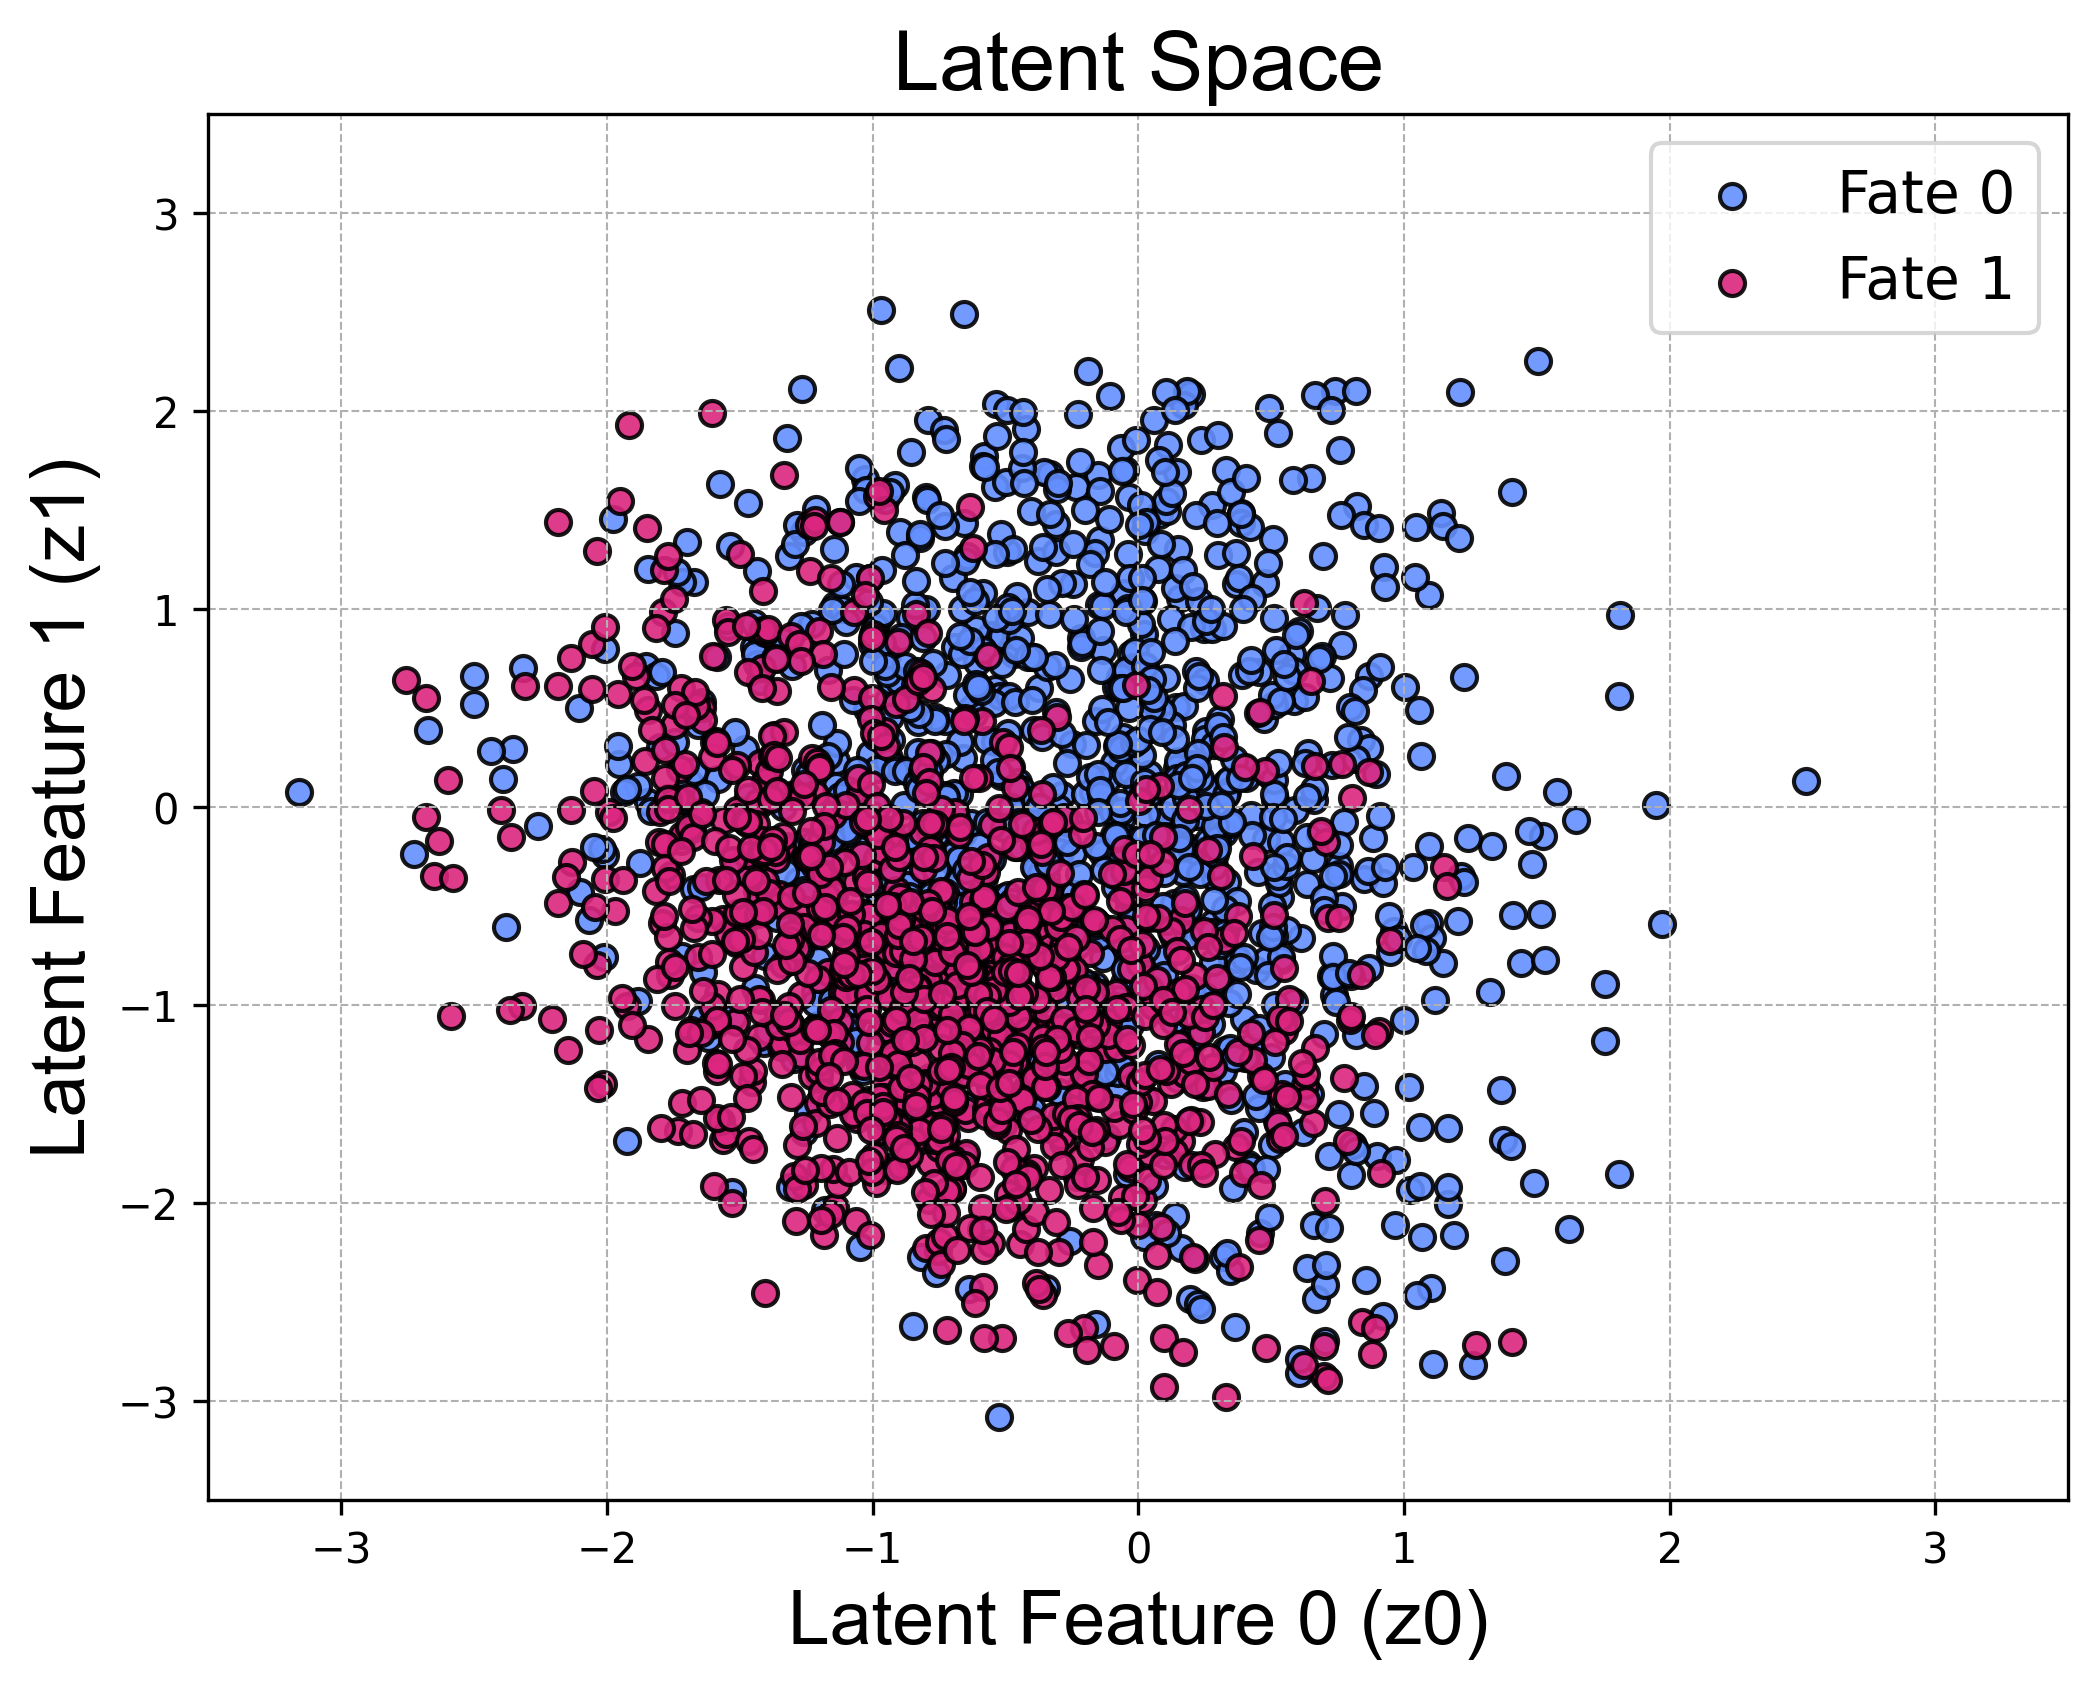

In [6]:
# Predict the latent representations
latent_2d = encoder.predict(x_train)  # Shape (1380, 2)

# Compute mean localization (centroids) for each class
# centroid_0 = latent_2d[y_train == 0].mean(axis=0)  # Mean of class 0
# centroid_1 = latent_2d[y_train == 1].mean(axis=0)  # Mean of class 1
# centroids = np.array([centroid_0, centroid_1])

# Find extreme points for axis limits
x_min, x_max = latent_2d[:, 0].min() - 0.5, latent_2d[:, 0].max() + 0.5
y_min, y_max = latent_2d[:, 1].min() - 0.5, latent_2d[:, 1].max() + 0.5

# Create the plot
plt.figure(figsize=(8, 6), dpi=300)

# Scatter plot for each class separately
plt.scatter(latent_2d[y_train == 0][:, 0], latent_2d[y_train == 0][:, 1], 
            color='#648fff', label="Fate 0", alpha=0.9, edgecolors='k') #
plt.scatter(latent_2d[y_train == 1][:, 0], latent_2d[y_train == 1][:, 1], 
            color='#dc267f', label="Fate 1", alpha=0.9, edgecolors='k') 

# Plot centroids as black crosses
#plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=200, label="Class Centroids")

# Decision boundary: Find midpoint of centroids and plot the separating line
#x_vals = np.linspace(x_min, x_max, 100)
#slope = -(centroid_1[0] - centroid_0[0]) / (centroid_1[1] - centroid_0[1])
#intercept = (centroid_0[1] + centroid_1[1]) / 2 - slope * (centroid_0[0] + centroid_1[0]) / 2
#plt.plot(x_vals, slope * x_vals + intercept, 'k--', label="Decision Boundary")

# Set dynamic axis limits
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)

plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

# Increase font size and set Arial font
plt.xlabel("Latent Feature 0 (z0)", fontsize=18, fontname="Arial")
plt.ylabel("Latent Feature 1 (z1)", fontsize=18, fontname="Arial")
plt.title("Latent Space", fontsize=20, fontname="Arial")
plt.legend(fontsize=14)
plt.grid(True, linestyle="--", linewidth=0.5)

# Save as high-quality SVG and PDF
#plt.savefig("latent_space_cellfate.svg", format="svg", bbox_inches="tight")
plt.savefig("latent_space_cellfate_nocent.pdf", format="pdf", bbox_inches="tight")

plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


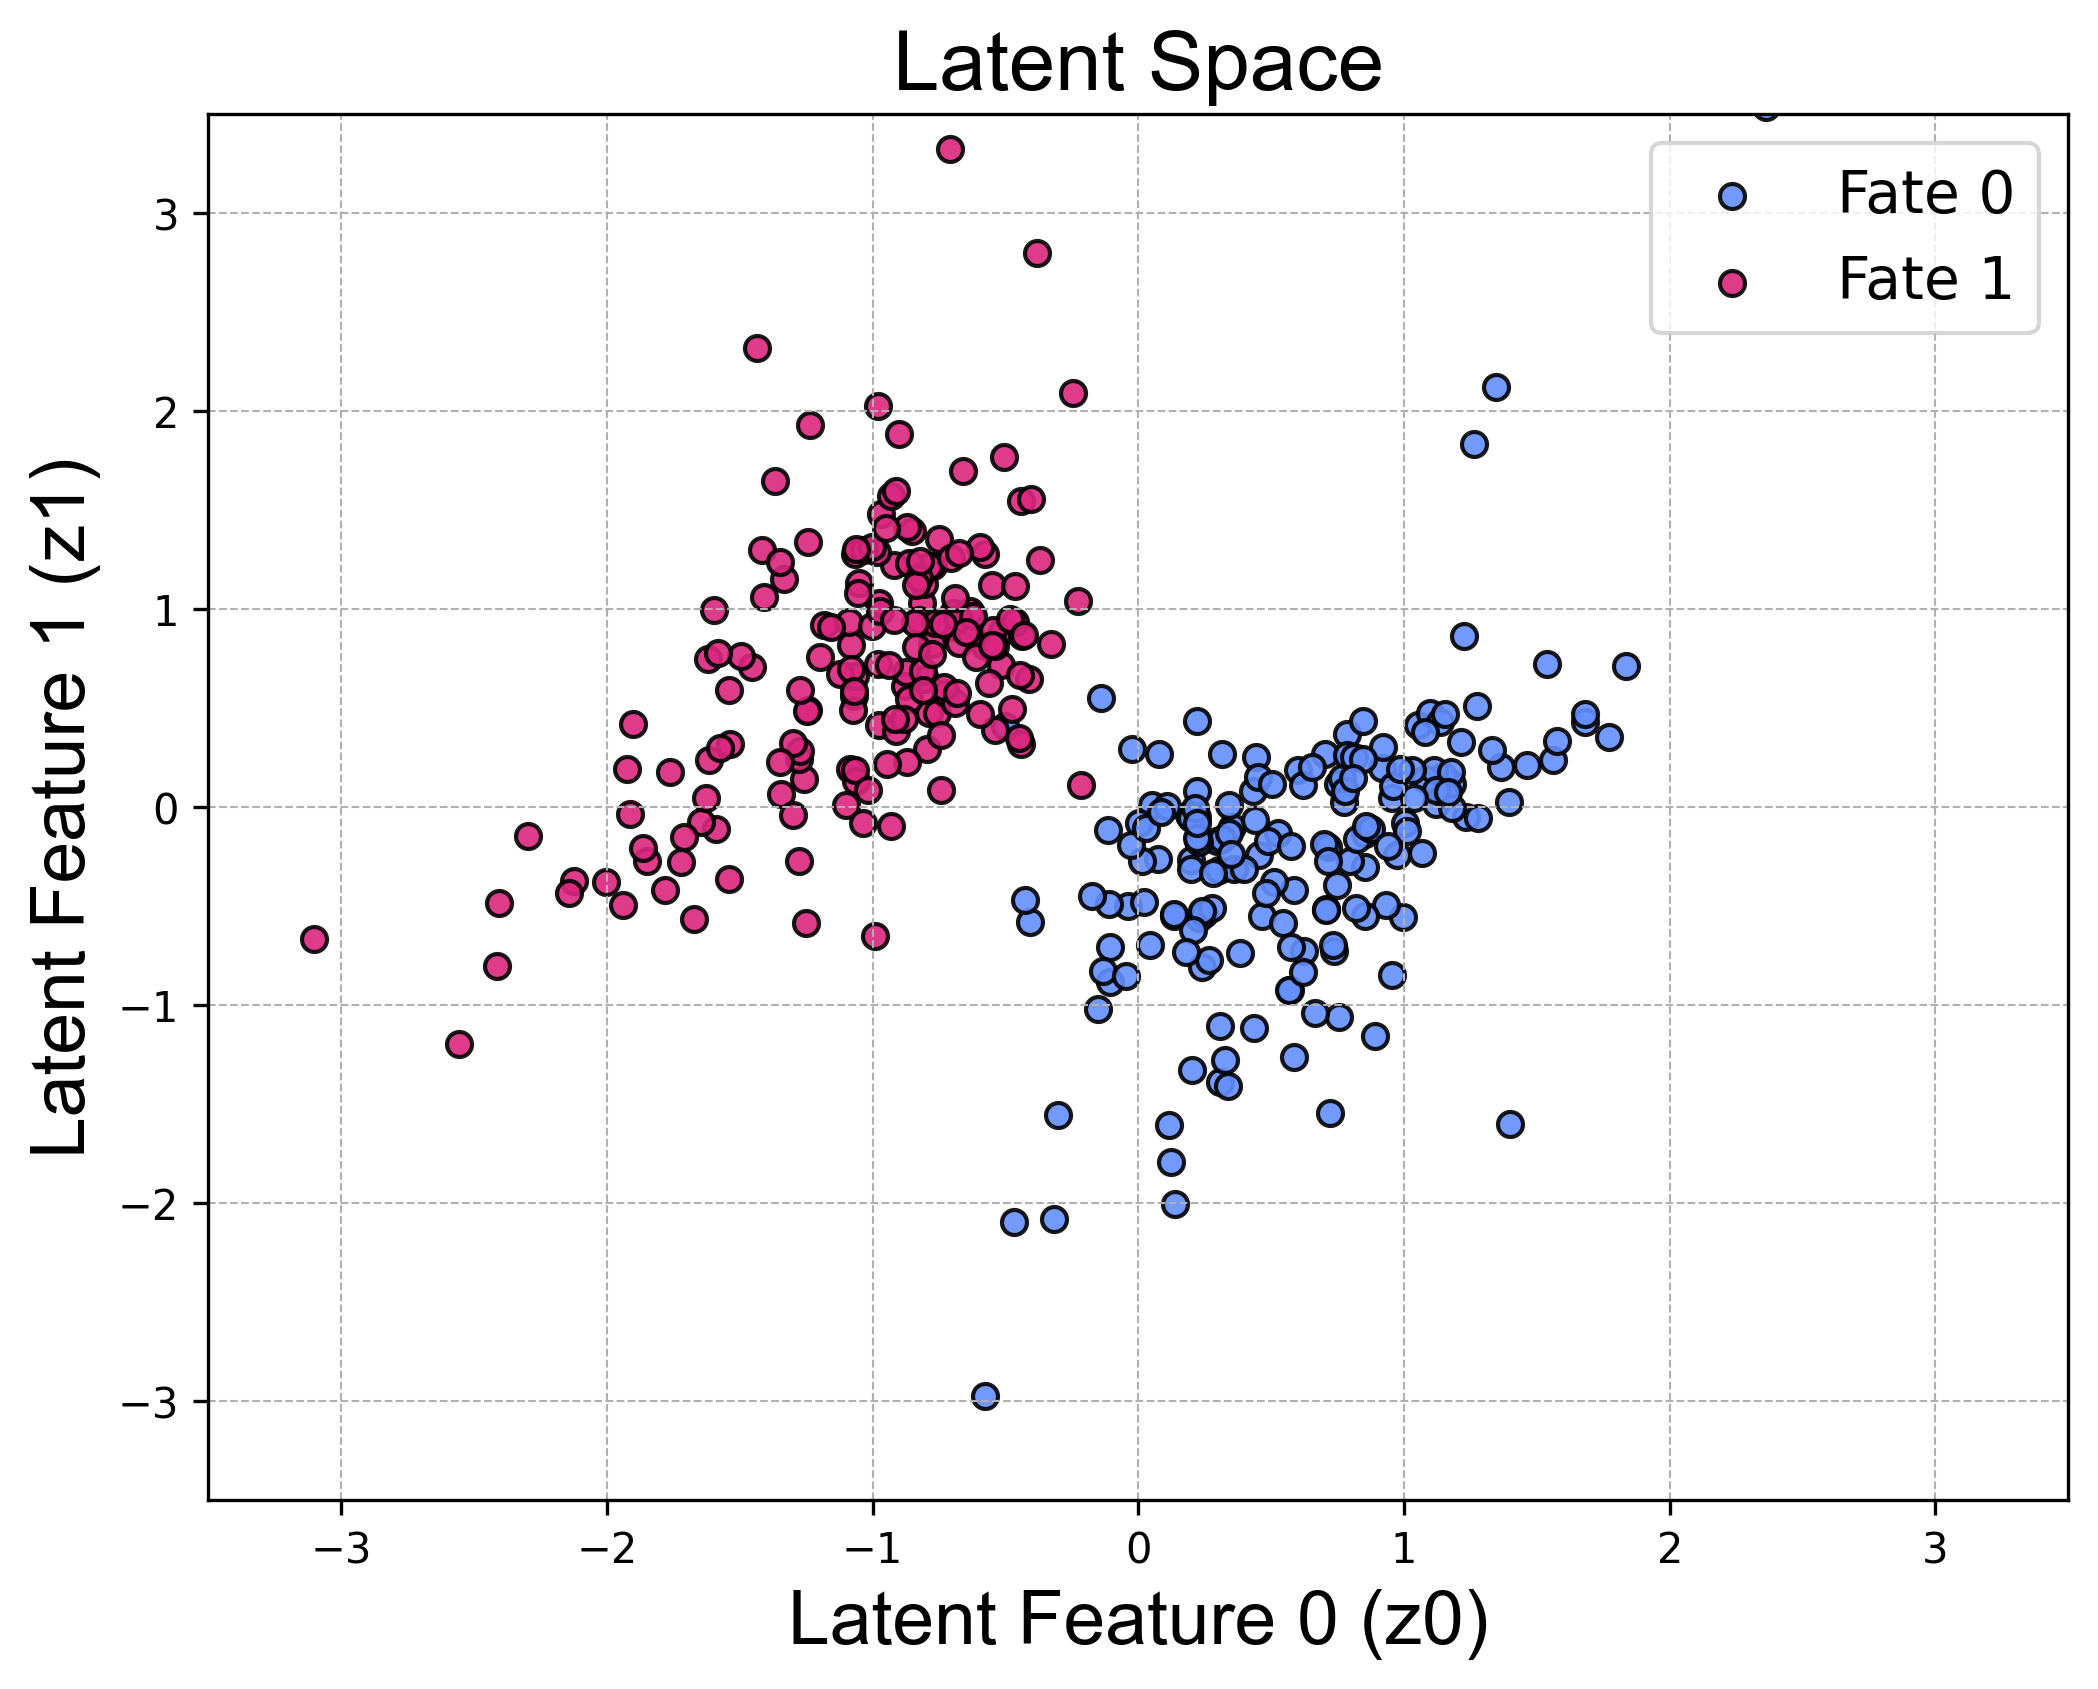

In [16]:
# Predict the latent representations
latent_2d = encoder.predict(x_train)  # Shape (1380, 2)

# Compute mean localization (centroids) for each class
# centroid_0 = latent_2d[y_train == 0].mean(axis=0)  # Mean of class 0
# centroid_1 = latent_2d[y_train == 1].mean(axis=0)  # Mean of class 1
# centroids = np.array([centroid_0, centroid_1])

# Find extreme points for axis limits
x_min, x_max = latent_2d[:, 0].min() - 0.5, latent_2d[:, 0].max() + 0.5
y_min, y_max = latent_2d[:, 1].min() - 0.5, latent_2d[:, 1].max() + 0.5

# Create the plot
plt.figure(figsize=(8, 6), dpi=300)

# Scatter plot for each class separately
plt.scatter(latent_2d[y_train == 0][:, 0], latent_2d[y_train == 0][:, 1], 
            color='#648fff', label="Fate 0", alpha=0.9, edgecolors='k') #
plt.scatter(latent_2d[y_train == 1][:, 0], latent_2d[y_train == 1][:, 1], 
            color='#dc267f', label="Fate 1", alpha=0.9, edgecolors='k') 

# Plot centroids as black crosses
#plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=200, label="Class Centroids")

# Decision boundary: Find midpoint of centroids and plot the separating line
#x_vals = np.linspace(x_min, x_max, 100)
#slope = -(centroid_1[0] - centroid_0[0]) / (centroid_1[1] - centroid_0[1])
#intercept = (centroid_0[1] + centroid_1[1]) / 2 - slope * (centroid_0[0] + centroid_1[0]) / 2
#plt.plot(x_vals, slope * x_vals + intercept, 'k--', label="Decision Boundary")

# Set dynamic axis limits
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)

plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

# Increase font size and set Arial font
plt.xlabel("Latent Feature 0 (z0)", fontsize=18, fontname="Arial")
plt.ylabel("Latent Feature 1 (z1)", fontsize=18, fontname="Arial")
plt.title("Latent Space", fontsize=20, fontname="Arial")
plt.legend(fontsize=14)
plt.grid(True, linestyle="--", linewidth=0.5)

# Save as high-quality SVG and PDF
#plt.savefig("latent_space_cellfate.svg", format="svg", bbox_inches="tight")
#plt.savefig("latent_space_cellfate_nocent.pdf", format="pdf", bbox_inches="tight")

plt.show()

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


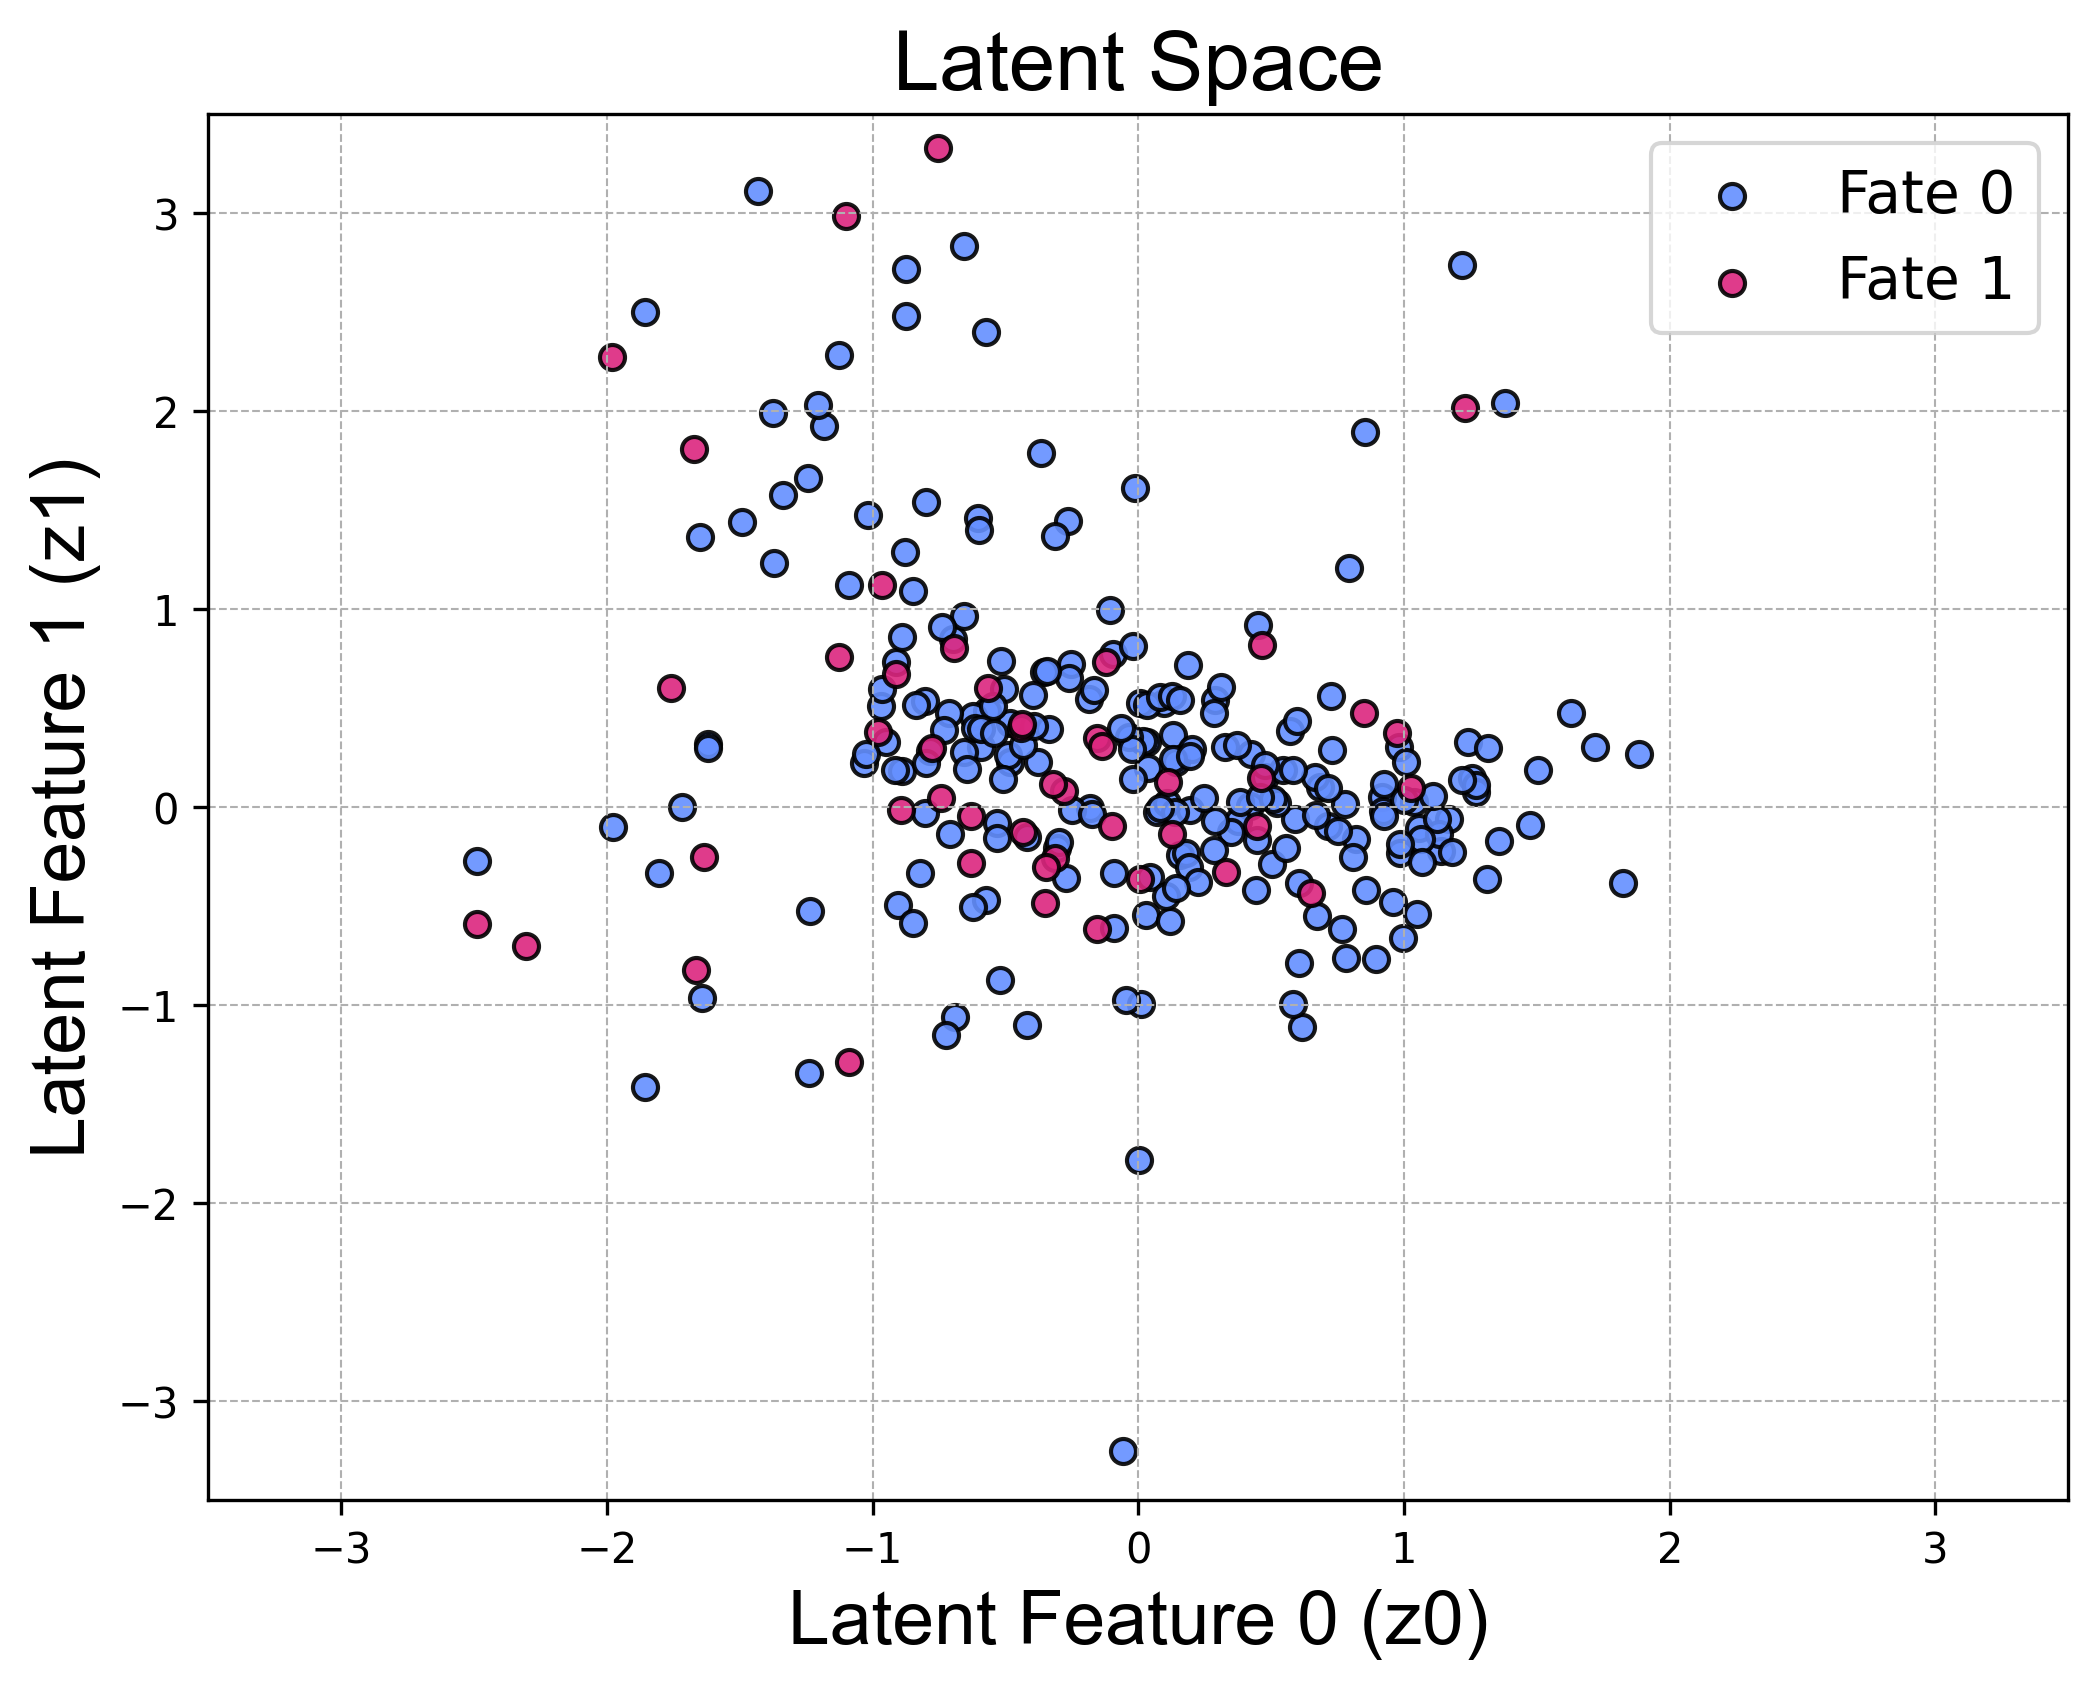

In [18]:
# Predict the latent representations
latent_2d = encoder.predict(x_test)  # Shape (1380, 2)

# Compute mean localization (centroids) for each class
# centroid_0 = latent_2d[y_train == 0].mean(axis=0)  # Mean of class 0
# centroid_1 = latent_2d[y_train == 1].mean(axis=0)  # Mean of class 1
# centroids = np.array([centroid_0, centroid_1])

# Find extreme points for axis limits
x_min, x_max = latent_2d[:, 0].min() - 0.5, latent_2d[:, 0].max() + 0.5
y_min, y_max = latent_2d[:, 1].min() - 0.5, latent_2d[:, 1].max() + 0.5

# Create the plot
plt.figure(figsize=(8, 6), dpi=300)

# Scatter plot for each class separately
plt.scatter(latent_2d[y_test == 0][:, 0], latent_2d[y_test == 0][:, 1], 
            color='#648fff', label="Fate 0", alpha=0.9, edgecolors='k') #
plt.scatter(latent_2d[y_test == 1][:, 0], latent_2d[y_test == 1][:, 1], 
            color='#dc267f', label="Fate 1", alpha=0.9, edgecolors='k') 

# Plot centroids as black crosses
#plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='X', s=200, label="Class Centroids")

# Decision boundary: Find midpoint of centroids and plot the separating line
#x_vals = np.linspace(x_min, x_max, 100)
#slope = -(centroid_1[0] - centroid_0[0]) / (centroid_1[1] - centroid_0[1])
#intercept = (centroid_0[1] + centroid_1[1]) / 2 - slope * (centroid_0[0] + centroid_1[0]) / 2
#plt.plot(x_vals, slope * x_vals + intercept, 'k--', label="Decision Boundary")

# Set dynamic axis limits
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)

plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)

# Increase font size and set Arial font
plt.xlabel("Latent Feature 0 (z0)", fontsize=18, fontname="Arial")
plt.ylabel("Latent Feature 1 (z1)", fontsize=18, fontname="Arial")
plt.title("Latent Space", fontsize=20, fontname="Arial")
plt.legend(fontsize=14)
plt.grid(True, linestyle="--", linewidth=0.5)

# Save as high-quality SVG and PDF
#plt.savefig("latent_space_cellfate.svg", format="svg", bbox_inches="tight")
#plt.savefig("latent_space_cellfate_nocent.pdf", format="pdf", bbox_inches="tight")

plt.show()

In [25]:
from scipy.stats import ttest_ind
import numpy as np

# Assuming 'latent_space' is your encoder output for the test set and 'y_test' are the labels
latent_space = encoder.predict(x_test)

# Select the two features you want to test
feat_0 = 0
feat_1 = 1

# Split latent features by class (0 and 1)
class_0_feat_0 = latent_space[y_test == 0, feat_0]
class_1_feat_0 = latent_space[y_test == 1, feat_0]

class_0_feat_1 = latent_space[y_test == 0, feat_1]
class_1_feat_1 = latent_space[y_test == 1, feat_1]

# Perform t-tests for both features
t_stat_feat_0, p_val_feat_0 = ttest_ind(class_0_feat_0, class_1_feat_0)
t_stat_feat_1, p_val_feat_1 = ttest_ind(class_0_feat_1, class_1_feat_1)

print(f"T-test for feature 0:")
print(f"T-statistic: {t_stat_feat_0}, P-value: {p_val_feat_0}")

print(f"T-test for feature 1:")
print(f"T-statistic: {t_stat_feat_1}, P-value: {p_val_feat_1}")

# Check if the p-values are smaller than a significance level (e.g., 0.05)
if p_val_feat_0 < 0.05:
    print("Feature 0 is significantly different between the classes.")
else:
    print("Feature 0 is not significantly different between the classes.")

if p_val_feat_1 < 0.05:
    print("Feature 1 is significantly different between the classes.")
else:
    print("Feature 1 is not significantly different between the classes.")


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
T-test for feature 0:
T-statistic: 4.354092796482625, P-value: 1.886978441570459e-05
T-test for feature 1:
T-statistic: -2.2223460302934717, P-value: 0.02707349368663433
Feature 0 is significantly different between the classes.
Feature 1 is significantly different between the classes.


In [27]:
# I want 5 numbers equally spaced between -3 and 2

np.linspace(-3, 2, 5)

array([-3.  , -1.75, -0.5 ,  0.75,  2.  ])

In [30]:
np.linspace(-2.5, 1.5, 5)

array([-2.5, -1.5, -0.5,  0.5,  1.5])

(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


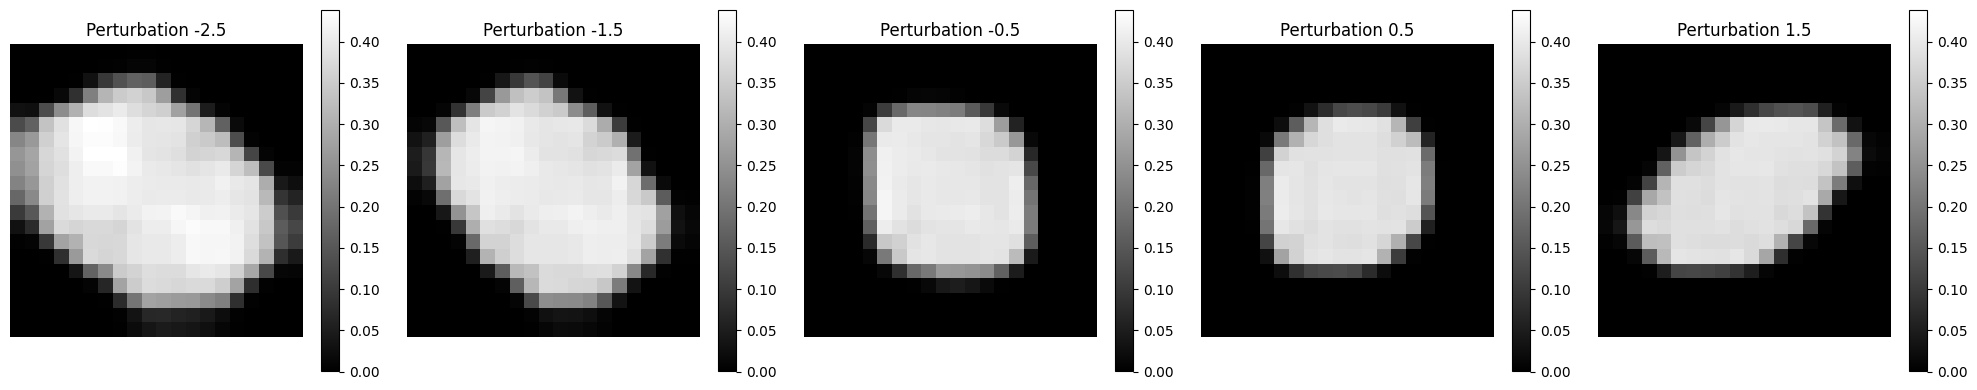

In [12]:
baseline_latent_vector = np.zeros((2, 2), dtype=np.float32)  # Start with a neutral latent vector

# Choose the feature to perturb (e.g., feature 0)
feature_index = 1

# Perturbation range
#perturbations = [-3, -2, -1, 0, 1, 2]  
perturbations = np.linspace(-3, 2, 5) # feature index 1
perturbations = np.linspace(-2.5, 1.5, 5) # feature index 0

#perturbations = [-0.4, -0.3, -0.1, 0, 0.1, 0.2, 0.5] 
#perturbations = np.linspace(-3, 3, 7)

# Store the perturbed reconstructions
perturbed_reconstructions = []

for value in perturbations:
    # Create a copy of the baseline latent vector
    perturbed_vector = baseline_latent_vector.copy()
    print(perturbed_vector.shape)
    # Modify the selected feature
    perturbed_vector[0, feature_index] = value
    
    # Decode the perturbed vector to generate a synthetic image
    synthetic_image = decoder.predict(perturbed_vector)  # Assuming 'decoder' is your trained decoder model
    
    # Store the result
    perturbed_reconstructions.append(synthetic_image[0])  # Assuming decoder outputs (batch_size, height, width, channels)

# Convert list to numpy array for easier handling
perturbed_reconstructions = np.array(perturbed_reconstructions)

# Plot the results
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
vmin = perturbed_reconstructions.min()
vmax = perturbed_reconstructions.max()

for i in range(5):
    im = axs[i].imshow(perturbed_reconstructions[i, :, :, 0], cmap='gray', vmin=vmin, vmax=vmax)
    axs[i].set_title(f'Perturbation {perturbations[i]}')
    axs[i].axis('off')
    fig.colorbar(im, ax=axs[i])

plt.tight_layout()
plt.savefig("perturbations_feat1.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()


(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(2, 2)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


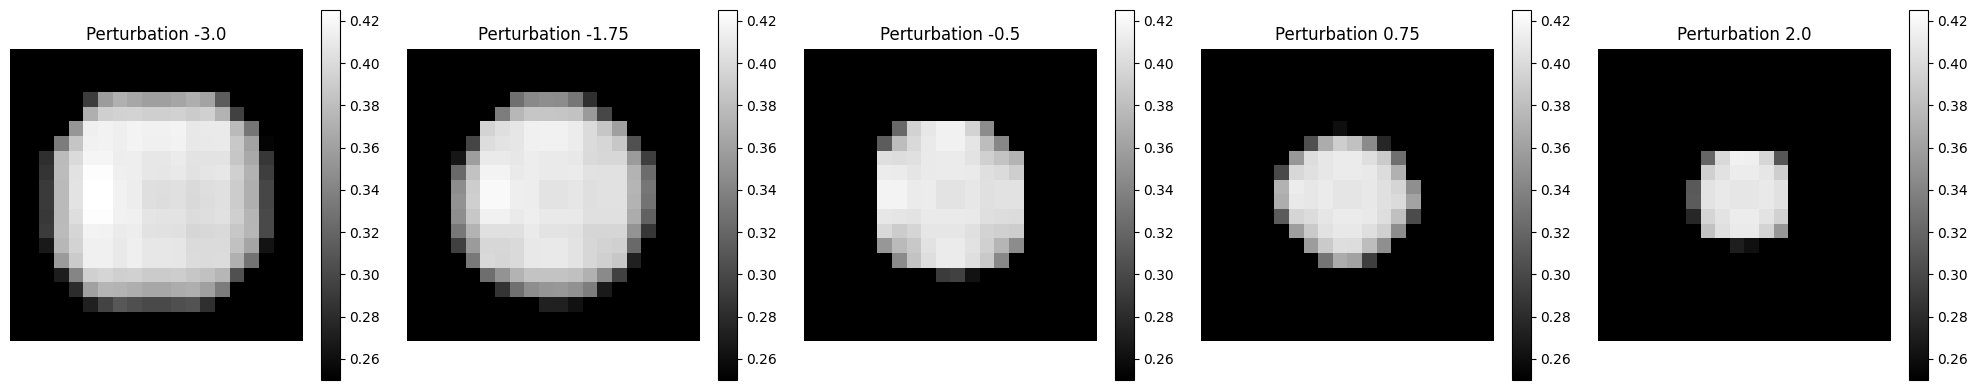

In [ ]:
baseline_latent_vector = np.zeros((2, 2), dtype=np.float32)  # Start with a neutral latent vector

# Choose the feature to perturb (e.g., feature 0)
feature_index = 1

# Perturbation range
#perturbations = [-3, -2, -1, 0, 1, 2]  
perturbations = np.linspace(-3, 2, 5) # feature index 1
perturbations = np.linspace(-2.5, 1.5, 5) # feature index 0

#perturbations = [-0.4, -0.3, -0.1, 0, 0.1, 0.2, 0.5] 
#perturbations = np.linspace(-3, 3, 7)

# Store the perturbed reconstructions
perturbed_reconstructions = []

for value in perturbations:
    # Create a copy of the baseline latent vector
    perturbed_vector = baseline_latent_vector.copy()
    print(perturbed_vector.shape)
    # Modify the selected feature
    perturbed_vector[0, feature_index] = value
    
    # Decode the perturbed vector to generate a synthetic image
    synthetic_image = decoder.predict(perturbed_vector)  # Assuming 'decoder' is your trained decoder model
    
    # Store the result
    perturbed_reconstructions.append(synthetic_image[0])  # Assuming decoder outputs (batch_size, height, width, channels)

# Convert list to numpy array for easier handling
perturbed_reconstructions = np.array(perturbed_reconstructions)

# Plot the results
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
vmin = perturbed_reconstructions.min()
vmax = perturbed_reconstructions.max()

for i in range(5):
    im = axs[i].imshow(perturbed_reconstructions[i, :, :, 0], cmap='gray', vmin=0.25, vmax=vmax)
    axs[i].set_title(f'Perturbation {perturbations[i]}')
    axs[i].axis('off')
    fig.colorbar(im, ax=axs[i])

plt.tight_layout()
plt.savefig("perturbations_feat1.pdf", format="pdf", dpi=300, bbox_inches="tight")
plt.show()


feature extraction from these images (both features)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


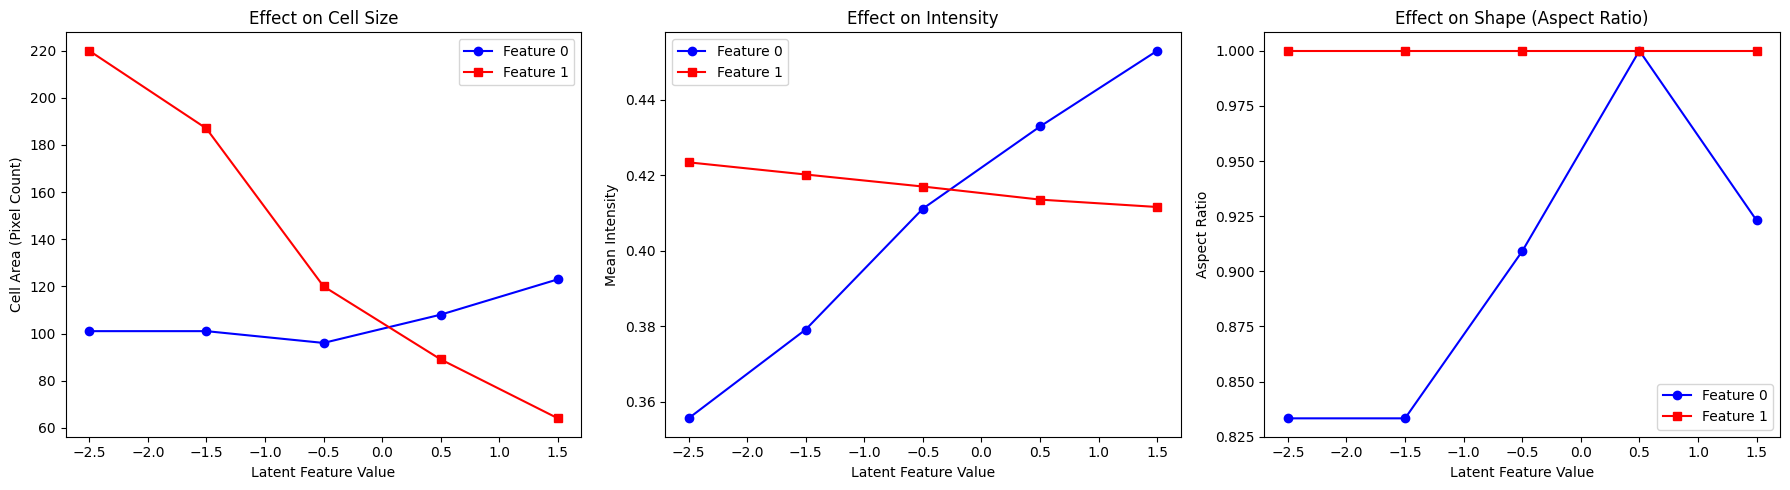

In [33]:
import cv2

# Initialize arrays to store feature effects
areas_0, areas_1 = [], []
intensities_0, intensities_1 = [], []
aspect_ratios_0, aspect_ratios_1 = [], []
circularities_0, circularities_1 = [], []

# Function to compute cell area
def compute_area(image, threshold=0.1):
    return np.sum(image > threshold)

# Function to compute mean intensity
def compute_intensity(image):
    return np.max(image)

# Function to compute shape descriptors (aspect ratio, circularity)
def compute_shape_features(image, threshold=0.1):
    binary = (image > threshold).astype(np.uint8)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return 0, 0  
    
    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / h
    
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    circularity = 4 * np.pi * (area / (perimeter ** 2 + 1e-6))  # Avoid division by zero
    
    return aspect_ratio, circularity

perturbations = np.linspace(-2.5, 1.5, 5)

# Iterate over both latent features
for feature_index in [0, 1]:
    for value in perturbations:
        # Create perturbed latent vector
        perturbed_vector = np.zeros((2, 2), dtype=np.float32)
        perturbed_vector[0, feature_index] = value

        # Decode the perturbed vector to generate a synthetic image
        synthetic_image = decoder.predict(perturbed_vector)[0, :, :, 0]

        # Compute features
        area = compute_area(synthetic_image)
        intensity = compute_intensity(synthetic_image)
        aspect_ratio, circularity = compute_shape_features(synthetic_image)

        # Store results based on the feature being perturbed
        if feature_index == 0:
            areas_0.append(area)
            intensities_0.append(intensity)
            aspect_ratios_0.append(aspect_ratio)
            circularities_0.append(circularity)
        else:
            areas_1.append(area)
            intensities_1.append(intensity)
            aspect_ratios_1.append(aspect_ratio)
            circularities_1.append(circularity)

# Plot results
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Plot Cell Area
axs[0].plot(perturbations, areas_0, marker='o', color='blue', label="Feature 0")
axs[0].plot(perturbations, areas_1, marker='s', color='red', label="Feature 1")
axs[0].set_xlabel("Latent Feature Value")
axs[0].set_ylabel("Cell Area (Pixel Count)")
axs[0].set_title("Effect on Cell Size")
axs[0].legend()

# Plot Mean Intensity
axs[1].plot(perturbations, intensities_0, marker='o', color='blue', label="Feature 0")
axs[1].plot(perturbations, intensities_1, marker='s', color='red', label="Feature 1")
axs[1].set_xlabel("Latent Feature Value")
axs[1].set_ylabel("Mean Intensity")
axs[1].set_title("Effect on Intensity")
axs[1].legend()

# Plot Shape Descriptors (Aspect Ratio)
axs[2].plot(perturbations, aspect_ratios_0, marker='o', color='blue', label="Feature 0")
axs[2].plot(perturbations, aspect_ratios_1, marker='s', color='red', label="Feature 1")
axs[2].set_xlabel("Latent Feature Value")
axs[2].set_ylabel("Aspect Ratio")
axs[2].set_title("Effect on Shape (Aspect Ratio)")
axs[2].legend()

plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


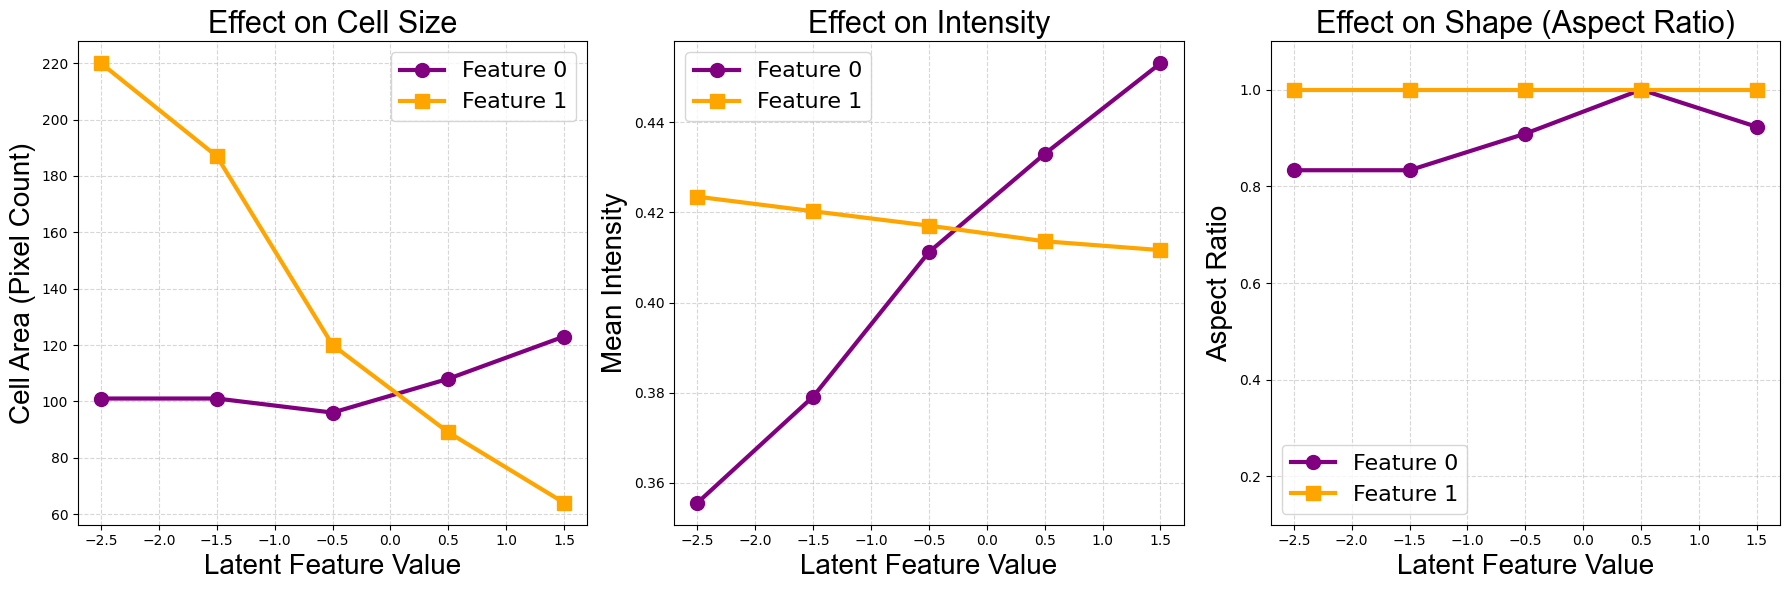

In [48]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Initialize arrays to store feature effects
areas_0, areas_1 = [], []
intensities_0, intensities_1 = [], []
aspect_ratios_0, aspect_ratios_1 = [], []
circularities_0, circularities_1 = [], []

# Function to compute cell area
def compute_area(image, threshold=0.1):
    return np.sum(image > threshold)

# Function to compute mean intensity
def compute_intensity(image):
    return np.max(image)

# Function to compute shape descriptors (aspect ratio, circularity)
def compute_shape_features(image, threshold=0.1):
    binary = (image > threshold).astype(np.uint8)
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return 0, 0  
    
    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / h
    
    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)
    circularity = 4 * np.pi * (area / (perimeter ** 2 + 1e-6))  # Avoid division by zero
    
    return aspect_ratio, circularity

# Perturbation values
perturbations = np.linspace(-2.5, 1.5, 5)

# Iterate over both latent features
for feature_index in [0, 1]:
    for value in perturbations:
        # Create perturbed latent vector
        perturbed_vector = np.zeros((2, 2), dtype=np.float32)
        perturbed_vector[0, feature_index] = value

        # Decode the perturbed vector to generate a synthetic image
        synthetic_image = decoder.predict(perturbed_vector)[0, :, :, 0]

        # Compute features
        area = compute_area(synthetic_image)
        intensity = compute_intensity(synthetic_image)
        aspect_ratio, circularity = compute_shape_features(synthetic_image)

        # Store results based on the feature being perturbed
        if feature_index == 0:
            areas_0.append(area)
            intensities_0.append(intensity)
            aspect_ratios_0.append(aspect_ratio)
            circularities_0.append(circularity)
        else:
            areas_1.append(area)
            intensities_1.append(intensity)
            aspect_ratios_1.append(aspect_ratio)
            circularities_1.append(circularity)

# Define colors
# color_0 = "#E69F00"  # Orange
# color_1 = "#009E73"  # Teal
color_0 = "purple"
color_1 = "orange"

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot Cell Area
axs[0].plot(perturbations, areas_0, marker='o', color=color_0, markersize=10, linewidth=3, label="Feature 0")
axs[0].plot(perturbations, areas_1, marker='s', color=color_1, markersize=10, linewidth=3, label="Feature 1")
axs[0].set_xlabel("Latent Feature Value", fontsize=20, fontname="Arial")
axs[0].set_ylabel("Cell Area (Pixel Count)", fontsize=20, fontname="Arial")
axs[0].set_title("Effect on Cell Size", fontsize=22, fontname="Arial")
axs[0].legend(fontsize=16)
axs[0].grid(True, linestyle="--", alpha=0.5)

# Plot Mean Intensity
axs[1].plot(perturbations, intensities_0, marker='o', color=color_0, markersize=10, linewidth=3, label="Feature 0")
axs[1].plot(perturbations, intensities_1, marker='s', color=color_1, markersize=10, linewidth=3, label="Feature 1")
axs[1].set_xlabel("Latent Feature Value", fontsize=20, fontname="Arial")
axs[1].set_ylabel("Mean Intensity", fontsize=20, fontname="Arial")
axs[1].set_title("Effect on Intensity", fontsize=22, fontname="Arial")
axs[1].legend(fontsize=16)
axs[1].grid(True, linestyle="--", alpha=0.5)

# Plot Shape Descriptors (Aspect Ratio)
axs[2].plot(perturbations, aspect_ratios_0, marker='o', color=color_0, markersize=10, linewidth=3, label="Feature 0")
axs[2].plot(perturbations, aspect_ratios_1, marker='s', color=color_1, markersize=10, linewidth=3, label="Feature 1")
axs[2].set_xlabel("Latent Feature Value", fontsize=20, fontname="Arial")
axs[2].set_ylabel("Aspect Ratio", fontsize=20, fontname="Arial")
axs[2].set_title("Effect on Shape (Aspect Ratio)", fontsize=22, fontname="Arial")
axs[2].set_ylim(0.1, 1.1)
axs[2].legend(fontsize=16)
axs[2].grid(True, linestyle="--", alpha=0.5)

# Adjust layout and save as high-quality images
plt.tight_layout()
# plt.savefig("feature_effects.svg", format="svg", bbox_inches="tight")
plt.savefig("feature_effects.pdf", format="pdf", bbox_inches="tight")

plt.show()


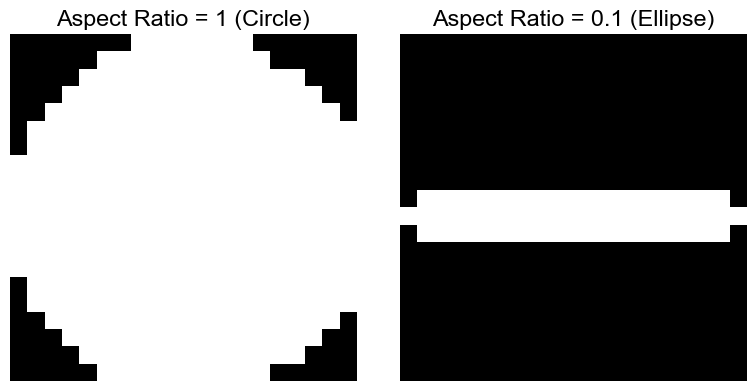

In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to create a binary mask with a given aspect ratio
def generate_shape(aspect_ratio, size=(20, 20)):
    img = np.zeros(size, dtype=np.uint8)
    center = (size[1] // 2, size[0] // 2)
    axes = (size[1] // 2, int((size[1] // 2) * aspect_ratio))
    
    cv2.ellipse(img, center, axes, 0, 0, 360, 255, -1)
    return img

# Generate shapes
circle = generate_shape(1)    # Perfect circle (aspect ratio = 1)
ellipse = generate_shape(0.1) # Elliptical shape (aspect ratio = 0.1)

# Plot the shapes
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(circle, cmap="gray")
axs[0].set_title("Aspect Ratio = 1 (Circle)")
axs[0].axis("off")

axs[1].imshow(ellipse, cmap="gray")
axs[1].set_title("Aspect Ratio = 0.1 (Ellipse)")
axs[1].axis("off")

plt.tight_layout()
plt.show()


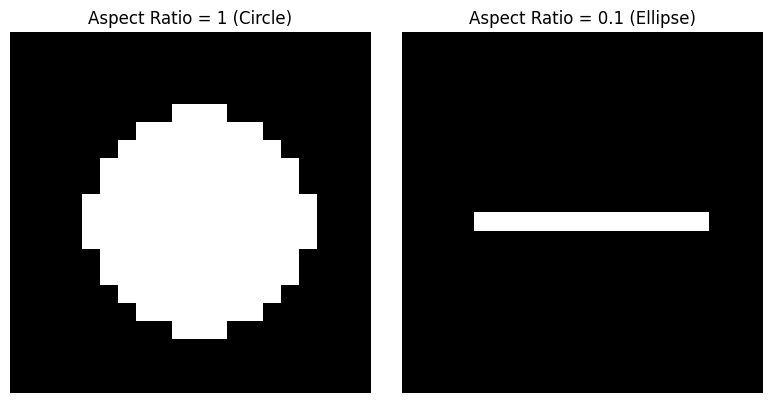

In [62]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to create a centered shape with reduced size
def generate_shape(aspect_ratio, size=(20, 20), scale=0.6):
    img = np.zeros(size, dtype=np.uint8)
    center = (size[1] // 2, size[0] // 2)

    # Reduce the size of the shape (60% of the image size)
    max_radius = int((size[1] // 2) * scale)  
    axes = (max_radius, int(max_radius * aspect_ratio))

    cv2.ellipse(img, center, axes, 0, 0, 360, 255, -1)
    return img

# Generate shapes
circle = generate_shape(1)    # Perfect circle (aspect ratio = 1)
ellipse = generate_shape(0.1) # Flattened ellipse (aspect ratio = 0.1)

# Plot the shapes
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(circle*0.1, cmap="gray", vmax=1)
axs[0].set_title("Aspect Ratio = 1 (Circle)")
axs[0].axis("off")

axs[1].imshow(ellipse, cmap="gray")
axs[1].set_title("Aspect Ratio = 0.1 (Ellipse)")
axs[1].axis("off")

plt.tight_layout()
plt.show()


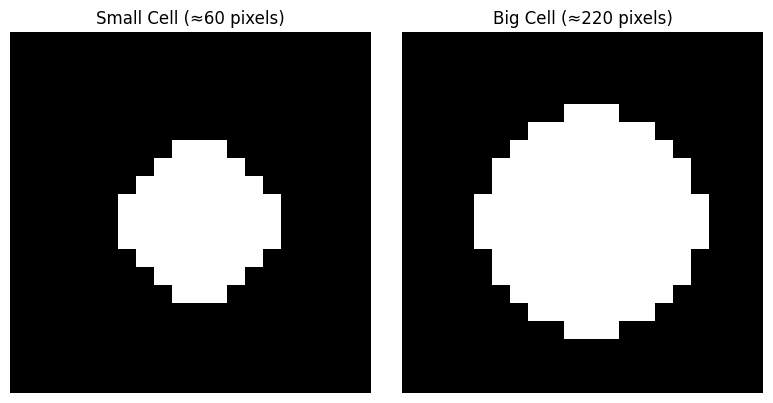

In [77]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to create a centered circle with a given pixel area
def generate_circle(area, size=(20, 20), scale=0.6):
    img = np.zeros(size, dtype=np.uint8)
    center = (size[1] // 2, size[0] // 2)

    # Compute radius from area (A = πr² -> r = sqrt(A/π))
    radius = int(np.sqrt(area / np.pi))

    # Ensure the shape is well-defined and centered
    max_radius = int((size[1] // 2) * scale)  # Scale max size
    radius = min(radius, max_radius)  # Limit radius

    cv2.ellipse(img, center, (radius, radius), 0, 0, 360, 255, -1)
    return img

# Generate circles
small_circle = generate_circle(60)    # Small cell (≈60 pixels)
big_circle = generate_circle(260)     # Big cell (≈220 pixels)

# Plot the shapes
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(small_circle, cmap="gray", vmax=255)
axs[0].set_title("Small Cell (≈60 pixels)")
axs[0].axis("off")

axs[1].imshow(big_circle, cmap="gray", vmax=255)
axs[1].set_title("Big Cell (≈220 pixels)")
axs[1].axis("off")

plt.tight_layout()
plt.show()


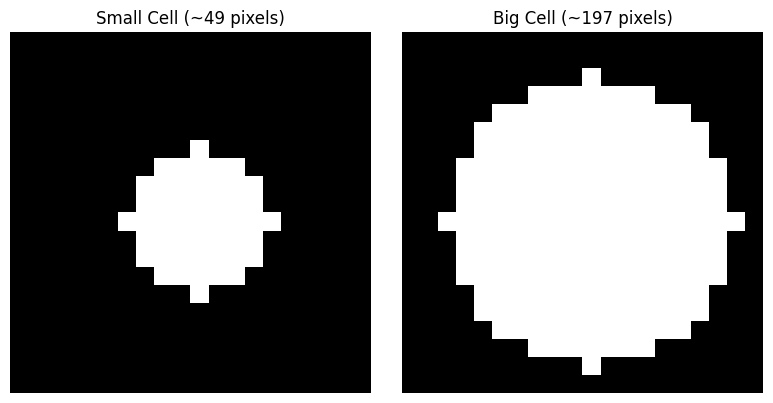

In [78]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Function to create a centered circle with an exact pixel area
def generate_circle(target_area, size=(20, 20)):
    img = np.zeros(size, dtype=np.uint8)
    center = (size[1] // 2, size[0] // 2)

    # Compute radius from the target area (A = πr² -> r = sqrt(A/π))
    radius = int(np.sqrt(target_area / np.pi))

    # Draw the circle
    cv2.circle(img, center, radius, 255, -1)

    return img

# Generate circles with accurate pixel areas
small_circle = generate_circle(60)   # Small cell (≈60 pixels)
big_circle = generate_circle(220)    # Big cell (≈220 pixels)

# Count the actual number of white pixels to verify correctness
small_pixels = np.sum(small_circle > 0)
big_pixels = np.sum(big_circle > 0)

# Plot the shapes
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(small_circle, cmap="gray", vmax=255)
axs[0].set_title(f"Small Cell (~{small_pixels} pixels)")
axs[0].axis("off")

axs[1].imshow(big_circle, cmap="gray", vmax=255)
axs[1].set_title(f"Big Cell (~{big_pixels} pixels)")
axs[1].axis("off")

plt.tight_layout()
plt.show()


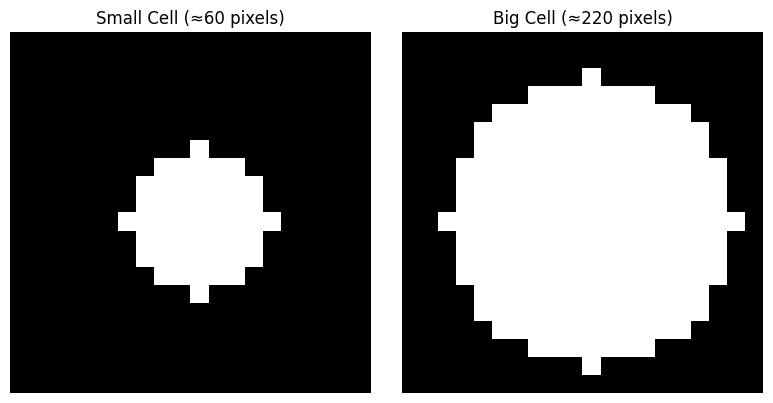

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Image size
size = 20

# Approximate areas
small_area = 60
big_area = 220

# Estimate radius for each area using the formula A = πr²
small_radius = int(np.sqrt(small_area / np.pi))
big_radius = int(np.sqrt(big_area / np.pi))

# Create empty images
small_cell = np.zeros((size, size), dtype=np.float32)
big_cell = np.zeros((size, size), dtype=np.float32)

# Define center
center = (size // 2, size // 2)

# Draw filled circles
cv2.circle(small_cell, center, small_radius, 1.0, -1)  # Small cell
cv2.circle(big_cell, center, big_radius, 1.0, -1)  # Big cell

# Plot both images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Small cell
axes[0].imshow(small_cell, cmap="gray", vmin=0, vmax=1)
axes[0].set_title("Small Cell (≈60 pixels)")
axes[0].axis("off")

# Big cell
axes[1].imshow(big_cell, cmap="gray", vmin=0, vmax=1)
axes[1].set_title("Big Cell (≈220 pixels)")
axes[1].axis("off")

plt.tight_layout()
plt.show()


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 0., 0., 0.],
       [0., 0., 0., 0., 1., 1.

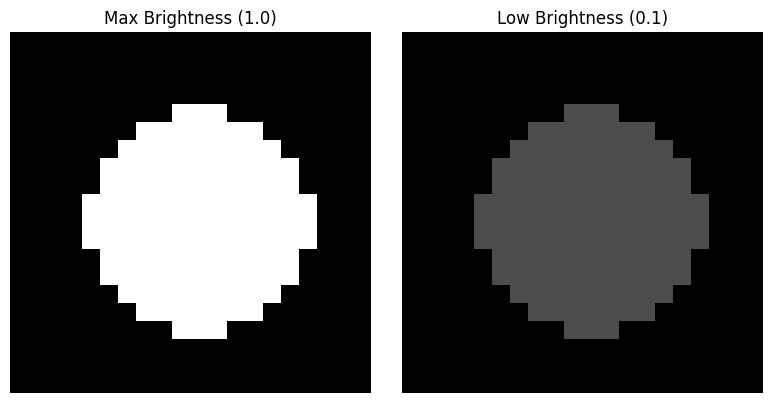

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

# Image size
size = 20
radius = 6  # Smaller radius to keep it centered with space around

# Create an empty image
circle_max = np.zeros((size, size), dtype=np.float32)
circle_low = np.zeros((size, size), dtype=np.float32)

# Define center
center = (size // 2, size // 2)

# Draw filled circles
cv2.circle(circle_max, center, radius, 1.0, -1)  # Brightness 1.0
cv2.circle(circle_low, center, radius, 0.1, -1)  # Brightness 0.1

# Plot both images
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

# Max brightness circle
axes[0].imshow(circle/255, cmap="gray", vmin=0, vmax=1)
axes[0].set_title("Max Brightness (1.0)")
axes[0].axis("off")

# Low brightness circle
axes[1].imshow(circle/255 * 0.3, cmap="gray", vmin=0, vmax=1)
axes[1].set_title("Low Brightness (0.1)")
axes[1].axis("off")

plt.tight_layout()
plt.show()


In [53]:
pre = np.load('precisions_10.npy')
diag = np.load('mean_diagonals_10.npy')

In [54]:
pre

array([0.75424354, 0.73253012, 0.69681335, 0.73058252, 0.7690387 ,
       0.70188004, 0.71611253, 0.7109375 , 0.74004684, 0.69123783,
       0.72110553])

In [55]:
diag

array([0.72168597, 0.71734234, 0.70865508, 0.74453024, 0.70801158,
       0.71766409, 0.71750322, 0.70849421, 0.73085586, 0.67696268,
       0.72651223])

In [58]:
np.load('precisions_seed43_9.npy')

array([0.69421488, 0.71863118, 0.80533146, 0.70557029, 0.71898734,
       0.70827858, 0.704     , 0.79314201, 0.7685893 , 0.78175383,
       0.        ])

In [63]:
np.mean((np.load('precisions_seed43_9.npy'), np.load('precisions_9.npy')), axis=0)

array([0.72422921, 0.72558065, 0.75107241, 0.71807641, 0.74401302,
       0.70507931, 0.71005627, 0.75203975, 0.75431807, 0.73649583,
       0.        ])

In [2]:
import numpy as np
np.load('precisions_seed43_9.npy')

array([0.69421488, 0.71863118, 0.80533146, 0.70557029, 0.71898734,
       0.70827858, 0.704     , 0.79314201, 0.7685893 , 0.78175383,
       0.        ])

In [20]:
precisions_seed42 = np.load('precisions_10.npy')
precisions_seed43 = np.sum((np.load('precisions_seed43_9.npy'), np.load('precisions_seed43_10.npy')), axis=0)
precisions_seed44 = np.sum((np.load('precisions_seed44_0.npy'), np.load('precisions_seed44_4.npy'), np.load('precisions_seed44_8.npy'), np.load('precisions_seed44_10.npy')), axis=0) 

In [25]:
diagonals_seed42 = np.load('mean_diagonals_10.npy')
diagonals_seed43 = np.sum((np.load('mean_diagonals_seed43_9.npy'), np.load('mean_diagonals_seed43_10.npy')), axis=0)
diagonals_seed44 = np.sum((np.load('mean_diagonals_seed44_0.npy'), np.load('mean_diagonals_seed44_4.npy'), np.load('mean_diagonals_seed44_8.npy'), np.load('mean_diagonals_seed44_10.npy')), axis=0)

In [ ]:
# np.save('precisions_seed42.npy', precisions_seed42)
# np.save('precisions_seed43.npy', precisions_seed43)
# np.save('precisions_seed44.npy', precisions_seed44)

array([0.76163207, 0.71354839, 0.72992701, 0.74004684, 0.74085603,
       0.7424594 , 0.81530782, 0.7       , 0.77300613, 0.74905803,
       0.79314201])

In [21]:
precisions_seed42.shape

(11,)

In [34]:
diagonals_tabular_seed42 = np.load('mean_diagonals_tabular_seed42.npy')[:,0]
diagonals_tabular_seed43 = np.load('mean_diagonals_tabular_seed43.npy')[:,0]
diagonals_tabular_seed44 = np.load('mean_diagonals_tabular_seed44.npy')[:,0]

precisions_tabular_seed42 = np.load('precisions_tabular_seed42.npy')[:,0]
precisions_tabular_seed43 = np.load('precisions_tabular_seed43.npy')[:,0]
precisions_tabular_seed44 = np.load('precisions_tabular_seed44.npy')[:,0]

In [35]:
precisions_tabular_seed42.shape

(11,)

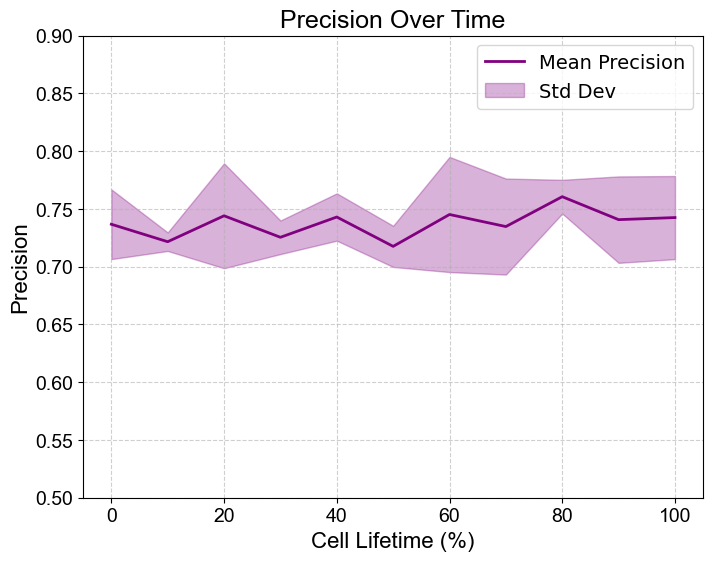

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Stack values to compute mean and std
precisions = np.vstack([precisions_seed42, precisions_seed43, precisions_seed44])
mean_precisions = np.mean(precisions, axis=0)
std_precisions = np.std(precisions, axis=0)

# Define time points (0% to 100% cell lifetime)
time_points = np.linspace(0, 100, len(mean_precisions))

# Plot with error bars
plt.figure(figsize=(8, 6))
plt.plot(time_points, mean_precisions, color='purple', label="Mean Precision", linewidth=2)
plt.fill_between(time_points, mean_precisions - std_precisions, mean_precisions + std_precisions,
                 color='purple', alpha=0.3, label="Std Dev")

# Formatting
plt.xlabel("Cell Lifetime (%)", fontsize=16, fontname="Arial")
plt.ylabel("Precision", fontsize=16, fontname="Arial")
plt.title("Precision Over Time", fontsize=18, fontname="Arial")
plt.xticks(fontsize=14, fontname="Arial")
plt.yticks(fontsize=14, fontname="Arial")
plt.ylim(0.5, 0.9)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=14)

# Save the figure with high quality
plt.savefig("precision_plot.pdf", dpi=300, bbox_inches="tight")
plt.show()


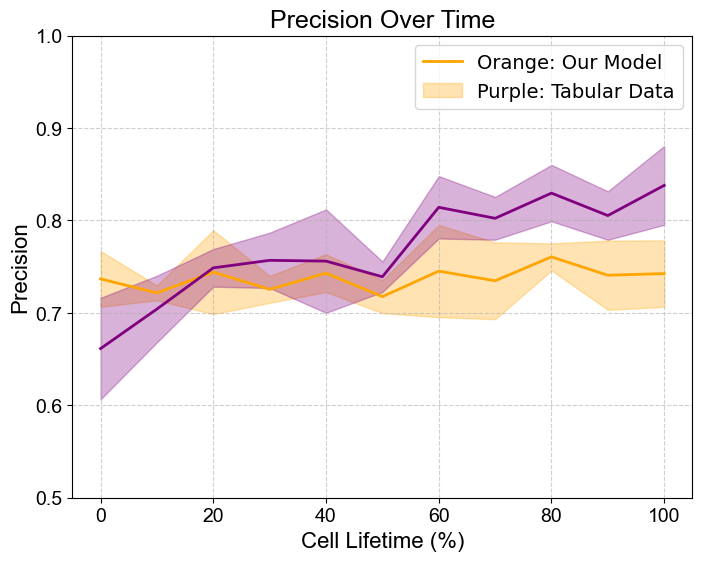

In [36]:
precisions = np.vstack([precisions_seed42, precisions_seed43, precisions_seed44])
mean_precisions = np.mean(precisions, axis=0)
std_precisions = np.std(precisions, axis=0)

precisions_tabular = np.vstack([precisions_tabular_seed42, precisions_tabular_seed43, precisions_tabular_seed44])
mean_precisions_tabular = np.mean(precisions_tabular, axis=0)
std_precisions_tabular = np.std(precisions_tabular, axis=0)

# Define time points (0% to 100% of cell lifetime)
time_points = np.linspace(0, 100, len(mean_precisions))

# Plot
plt.figure(figsize=(8, 6))

# Our model (Orange)
plt.plot(time_points, mean_precisions, color='orange', label="Our Model", linewidth=2)
plt.fill_between(time_points, mean_precisions - std_precisions, mean_precisions + std_precisions,
                 color='orange', alpha=0.3)

# Tabular Data (Purple)
plt.plot(time_points, mean_precisions_tabular, color='purple', label="Tabular Data", linewidth=2)
plt.fill_between(time_points, mean_precisions_tabular - std_precisions_tabular, 
                 mean_precisions_tabular + std_precisions_tabular, color='purple', alpha=0.3)

# Formatting
plt.xlabel("Cell Lifetime (%)", fontsize=16, fontname="Arial")
plt.ylabel("Precision", fontsize=16, fontname="Arial")
plt.title("Precision Over Time", fontsize=18, fontname="Arial")
plt.xticks(fontsize=14, fontname="Arial")
plt.yticks(fontsize=14, fontname="Arial")
plt.ylim(0.5, 1)  # Set y-axis range
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(["Orange: Our Model", "Purple: Tabular Data"], fontsize=14)

# Save the figure with high quality
#plt.savefig("precision_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

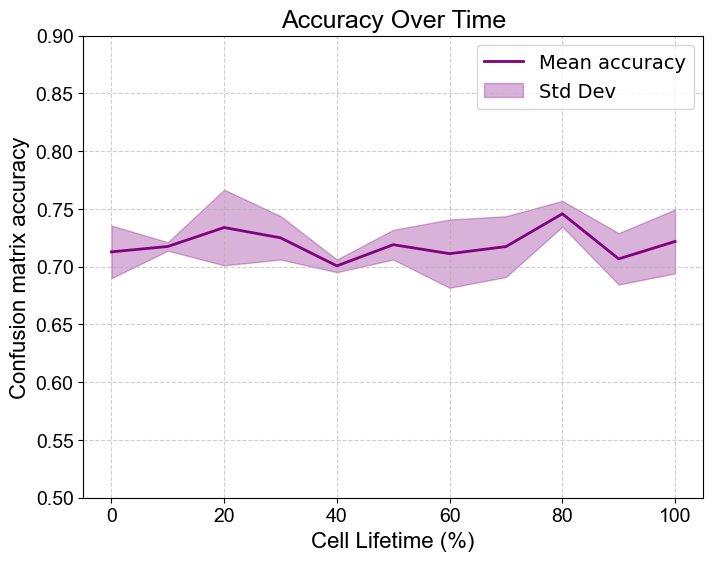

In [82]:
import numpy as np
import matplotlib.pyplot as plt

# Stack values to compute mean and std
diagonals = np.vstack([diagonals_seed42, diagonals_seed43, diagonals_seed44])
mean_precisions = np.mean(diagonals, axis=0)
std_precisions = np.std(diagonals, axis=0)

# Define time points (0% to 100% cell lifetime)
time_points = np.linspace(0, 100, len(mean_precisions))

# Plot with error bars
plt.figure(figsize=(8, 6))
plt.plot(time_points, mean_precisions, color='purple', label="Mean accuracy", linewidth=2)
plt.fill_between(time_points, mean_precisions - std_precisions, mean_precisions + std_precisions,
                 color='purple', alpha=0.3, label="Std Dev")

# Formatting
plt.xlabel("Cell Lifetime (%)", fontsize=16, fontname="Arial")
plt.ylabel("Confusion matrix accuracy", fontsize=16, fontname="Arial")
plt.title("Accuracy Over Time", fontsize=18, fontname="Arial")
plt.xticks(fontsize=14, fontname="Arial")
plt.yticks(fontsize=14, fontname="Arial")
plt.ylim(0.5, 0.9)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=14)

# Save the figure with high quality
plt.savefig("accuracy_plot.pdf", dpi=300, bbox_inches="tight")
plt.show()


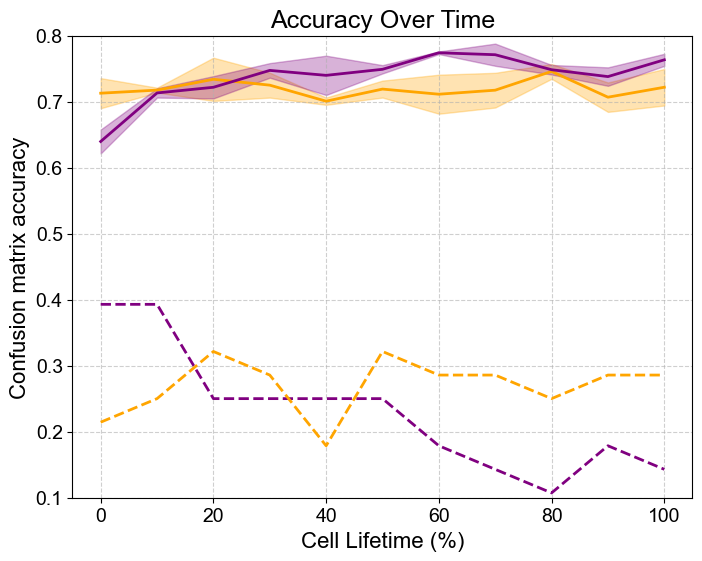

In [121]:
diagonals = np.vstack([diagonals_seed42, diagonals_seed43, diagonals_seed44])
mean_precisions = np.mean(diagonals, axis=0)
std_precisions = np.std(diagonals, axis=0)

diagonals_tabular = np.vstack([diagonals_tabular_seed42, diagonals_tabular_seed43, diagonals_tabular_seed44])
mean_precisions_tabular = np.mean(diagonals_tabular, axis=0)
std_precisions_tabular = np.std(diagonals_tabular, axis=0)

# Define time points (0% to 100% of cell lifetime)
time_points = np.linspace(0, 100, len(mean_precisions))

# Plot
plt.figure(figsize=(8, 6))

# Our model (Orange)
plt.plot(time_points, mean_precisions, color='orange', label="Our Model", linewidth=2)
plt.fill_between(time_points, mean_precisions - std_precisions, mean_precisions + std_precisions,
                 color='orange', alpha=0.3)

# Tabular Data (Purple)
plt.plot(time_points, mean_precisions_tabular, color='purple', label="Tabular Data", linewidth=2)
plt.fill_between(time_points, mean_precisions_tabular - std_precisions_tabular, 
                 mean_precisions_tabular + std_precisions_tabular, color='purple', alpha=0.3)

plt.plot(time_points, false_positives_tabular, linestyle='--', color='purple', label="False Negatives (Tabular)", linewidth=2)
plt.plot(time_points, false_positives_cellfate, linestyle='--', color='orange', label="False Negatives (Cellfate)", linewidth=2)


# Formatting
plt.xlabel("Cell Lifetime (%)", fontsize=16, fontname="Arial")
plt.ylabel("Confusion matrix accuracy", fontsize=16, fontname="Arial")
plt.title("Accuracy Over Time", fontsize=18, fontname="Arial")
plt.xticks(fontsize=14, fontname="Arial")
plt.yticks(fontsize=14, fontname="Arial")
plt.ylim(0.1, 0.8)  # Set y-axis range
plt.grid(True, linestyle="--", alpha=0.6)

# Save the figure with high quality
#plt.savefig("precision_comparison.png", dpi=300, bbox_inches="tight")
plt.show()

In [101]:
diagonals_seed42

array([0.72168597, 0.71734234, 0.70865508, 0.74453024, 0.70801158,
       0.71766409, 0.71750322, 0.70849421, 0.73085586, 0.67696268,
       0.72651223])

In [102]:
precisions_seed42

array([0.75424354, 0.73253012, 0.69681335, 0.73058252, 0.7690387 ,
       0.70188004, 0.71611253, 0.7109375 , 0.74004684, 0.69123783,
       0.72110553])

In [111]:
conf_matrix_cellfate = np.load('all_confusion_matrices_cellfate_10.npy')

In [115]:
conf_matrix_cellfate_final = np.sum((np.load('all_confusion_matrices_cellfate_6.npy'), np.load('all_confusion_matrices_cellfate_10.npy')), axis=0)

In [116]:
conf_matrix_cellfate_final

array([[[0.65765766, 0.34234234],
        [0.21428571, 0.78571429]],

       [[0.68468468, 0.31531532],
        [0.25      , 0.75      ]],

       [[0.73873874, 0.26126126],
        [0.32142857, 0.67857143]],

       [[0.77477477, 0.22522523],
        [0.28571429, 0.71428571]],

       [[0.59459459, 0.40540541],
        [0.17857143, 0.82142857]],

       [[0.75675676, 0.24324324],
        [0.32142857, 0.67857143]],

       [[0.72072072, 0.27927928],
        [0.28571429, 0.71428571]],

       [[0.7027027 , 0.2972973 ],
        [0.28571429, 0.71428571]],

       [[0.71171171, 0.28828829],
        [0.25      , 0.75      ]],

       [[0.63963964, 0.36036036],
        [0.28571429, 0.71428571]],

       [[0.73873874, 0.26126126],
        [0.28571429, 0.71428571]]])

In [114]:
np.load('all_confusion_matrices_cellfate_7.npy')

array([[[0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.7027027 , 0.2972973 ],
        [0.28571429, 0.71428571]],

       [[0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.        , 0.        ],
        [0.        , 0.        ]]])

In [112]:
conf_matrix_cellfate

array([[[0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.        , 0.        ],
        [0.        , 0.        ]],

       [[0.7027027 , 0.2972973 ],
        [0.28571429, 0.71428571]],

       [[0.71171171, 0.28828829],
        [0.25      , 0.75      ]],

       [[0.63963964, 0.36036036],
        [0.28571429, 0.71428571]],

       [[0.73873874, 0.26126126],
        [0.28571429, 0.71428571]]])

In [84]:
conf_matrices_tabular = np.load('all_confusion_matrices_tabular.npy')

In [85]:
conf_matrices_tabular

array([[[0.63063063, 0.36936937],
        [0.39285714, 0.60714286]],

       [[0.8018018 , 0.1981982 ],
        [0.39285714, 0.60714286]],

       [[0.65765766, 0.34234234],
        [0.25      , 0.75      ]],

       [[0.73873874, 0.26126126],
        [0.25      , 0.75      ]],

       [[0.71171171, 0.28828829],
        [0.25      , 0.75      ]],

       [[0.73873874, 0.26126126],
        [0.25      , 0.75      ]],

       [[0.72972973, 0.27027027],
        [0.17857143, 0.82142857]],

       [[0.72072072, 0.27927928],
        [0.14285714, 0.85714286]],

       [[0.62162162, 0.37837838],
        [0.10714286, 0.89285714]],

       [[0.63063063, 0.36936937],
        [0.17857143, 0.82142857]],

       [[0.64864865, 0.35135135],
        [0.14285714, 0.85714286]]])

In [120]:
false_negatives_tabular = [conf_matrices_tabular[t, 0, 1] for t in range(conf_matrices_tabular.shape[0])]
false_negatives_cellfate = [conf_matrix_cellfate_final[t, 0, 1] for t in range(conf_matrices_tabular.shape[0])]

false_positives_tabular = [conf_matrices_tabular[t, 1, 0] for t in range(conf_matrices_tabular.shape[0])]
false_positives_cellfate = [conf_matrix_cellfate_final[t, 1, 0] for t in range(conf_matrices_tabular.shape[0])]



In [118]:
false_negatives_cellfate

[0.34234234234234234,
 0.3153153153153153,
 0.26126126126126126,
 0.22522522522522523,
 0.40540540540540543,
 0.24324324324324326,
 0.27927927927927926,
 0.2972972972972973,
 0.2882882882882883,
 0.36036036036036034,
 0.26126126126126126]

In [95]:
false_negatives_tabular

[0.36936936936936937,
 0.1981981981981982,
 0.34234234234234234,
 0.26126126126126126,
 0.2882882882882883,
 0.26126126126126126,
 0.2702702702702703,
 0.27927927927927926,
 0.3783783783783784,
 0.36936936936936937,
 0.35135135135135137]